In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cadet_imports import *

import my_cadet_utils as cad_utils
import parameter_correlations as corr
import exploration_helper as explor

import multiprocessing as mp
import gc

from scipy import interpolate
from scipy import optimize
import time

In [3]:
# Ds = 1.8645997117750956e-16 # previous

In [4]:
def local_run_sim_fun(args):
    sim, res_file = args
    print(res_file[res_file.rfind('/'):])
    
#     run_time = time.time()
    cad_utils.run_simulation(sim, res_file)
#     rtime = (time.time()-run_time)/60.0
    return

def solve_time(time, frac, f):
    return f(time) - frac

def get_sim_data(args):               
    file_name, results_folder = args
    c_load, c_out, t, fVolum, Dp, d_part, l_col, Ds =\
    explor.get_sim_results_more_general(results_folder, file_name)

    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
    f = interpolate.interp1d(t, norm_c, kind='cubic')

    these_res = [fVolum, Dp, d_part, l_col, Ds]
    fracs = np.arange(0.01, 0.81, 0.01)

    for frac in fracs:
        idx = np.searchsorted(norm_c, frac, side="left")
        t_guess = t[idx]
        ftime = optimize.fsolve(solve_time, t_guess, args=(frac, f))[0]
        v_break  = ftime * fVolum
        cv_break = v_break/v_col
        fun_pe   = (cv_break - eps_c)/keq
        these_res.append(fun_pe)
#     print(file_name)
    return these_res

def get_xval(fVolum, d_part, Dp, l_col, eps_c, area_col):
    return fVolum*d_part**2/(Dp*l_col)/(eps_c * area_col)

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

In [5]:
def get_sim_data_keq_slope(args):               
    file_name, results_folder = args
    c_load, dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
    explor.get_sim_results(results_folder, file_name)

    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
    f = interpolate.interp1d(t, norm_c, kind='cubic')

    these_res = [fVolum, Dp, d_part, l_col, Ds, keq]
    fracs = np.arange(0.01, 0.81, 0.01)

    for frac in fracs:
        idx = np.searchsorted(norm_c, frac, side="left")
        t_guess = t[idx]
        ftime = optimize.fsolve(solve_time, t_guess, args=(frac, f))[0]
        v_break  = ftime * fVolum
        cv_break = v_break/v_col
        fun_pe   = (cv_break - eps_c)/keq
        these_res.append(fun_pe)
#     print(file_name)
    return these_res

def get_sim_data_keq(args):               
    file_name, results_folder = args
    c_load, Dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
    explor.get_sim_results(results_folder, file_name)
    these_res = [fVolum, Dp, d_part, l_col, Ds, keq]
    
    fracs = np.arange(0.01, 0.81, 0.01)
    try:
        d_col = 0.5e-2
        area_col = np.pi/4 * d_col**2
        v_col = area_col * l_col
        norm_c = c_out/c_load
        f = interpolate.interp1d(t, norm_c, kind='cubic')

        for frac in fracs:
            idx = np.searchsorted(norm_c, frac, side="left")
            t_guess = t[idx]
            ftime = optimize.fsolve(solve_time, t_guess, args=(frac, f))[0]
            v_break  = ftime * fVolum
            cv_break = v_break/v_col
            these_res.append(cv_break)
        return these_res
    
    except:
        print(file_name)
        empty = np.empty(len(fracs))
        empty[:] = np.NaN
        res = these_res + list(empty)
        return res

In [6]:
def get_D_combo_2(e_vals, Ds, Dp):
    w1 = 10.0**(e_vals[0])
    w2 = 10.0**(e_vals[1])
    return w1*Ds + w2*Dp

def mod_x_2(e_vals, df):
    df['D_combo'] = get_D_combo_2(e_vals, df['Ds'], df['Dp'])
    df['new_x'] = (df['v'] * df['d_part']**2) / (df['D_combo'] * df['l_col'])
    return df

def get_residuals_2(e_vals, df):
    df = mod_x_2(e_vals, df)
    df.sort_values(by='new_x', inplace=True)
    spl = interpolate.UnivariateSpline(df['new_x'], df['0.50']/(1.0-eps_t))
    spl.set_smoothing_factor(0.75)
    df['residual'] = df['0.50']/(1.0-eps_t) - spl(df['new_x'])
    return np.linalg.norm(df['residual'].values)

def get_sim_data_2(results_folder, file_name):               
    c_load, c_out, t, fVolum, Dp, d_part, l_col, Ds =\
    explor.get_sim_results_more_general(results_folder, file_name)
    
    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
   
    df_results = pd.DataFrame(np.array([t, c_out/c_load]).transpose(), columns=['time_s', 'c_normal'])
    df_results['CV'] = fVolum*df_results['time_s']/v_col
    
    return df_results

def get_sim_data_3(args):               
    results_folder, file_name = args
    c_load, Dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
    explor.get_sim_results(results_folder, file_name)
    
    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
        
    df_results = pd.DataFrame(np.array([t, c_out/c_load]).transpose(), columns=['time_s', 'c_normal'])
    df_results['CV'] = fVolum*df_results['time_s']/v_col
    return df_results

# Simulations


In [7]:
results_folder = Path().absolute() / 'sim_results_dispersion_terms'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_dispersion_terms'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

In [8]:
keq = 1000.0

eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

c_load = 2.0e-5

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

In [9]:
l_col = 5.0e-2
fVolum_vals = np.linspace(1.633e-9, 1.633e-8, 4)
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 4)
Dp_vals = np.linspace(1.0e-11, 4.0e-11, 2)
Ds_vals = np.append(np.logspace(-16, -11, 6), np.linspace(2.0e-11, 3.0e-11, 2))
Ds_vals

array([1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 2.e-11, 3.e-11])

## Run

In [46]:
## With multiprocessing
args_list = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for Ds in Ds_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Ds_{Ds:.1e}.h5'
                res_file = os.path.join(results_folder, file_name)

                V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
                t_max = 4.5*V_col/fVolum*(keq*(1-eps_t) + eps_t) + 5000
                ka    = explor.get_ka(keq, q_max)

                sim = cad_utils.get_more_general_system(load_c=c_load, 
                        Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max,
                        use_linear=False, fVolumetric=fVolum, d_part=d_part,
                        l_col=l_col)

                args = (sim, res_file)
                args_list.append(args)

In [47]:
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(local_run_sim_fun, args_list)
pool.close()
pool.join()

/Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-16.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-14.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-12.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_2.0e-11.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-16.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-14.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-12.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_2.0e-11.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-16.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-14.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-12.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_2.0e-11.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-16.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-14.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-12.h5
/Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_2.0

/Q_1.6e-08_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-16.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-14.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-12.h5
Simulation completed successfully
/Q_1.1e-08_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_3.0e-11.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_3.0e-11.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_2.0e-11.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-13.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-11.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-15.h5
Simulation completed successfully
/Q_1.6e-08_Dp_1.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-16.h5
Simulation completed successfully
/Q_1.1e-08_Dp_4.0e-11_dpart_1.

## Get data

In [416]:
files = []

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for Ds in Ds_vals:
                file_name = f'Q_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Ds_{Ds:.1e}.h5'
                files.append((file_name, results_folder))

pool      = mp.Pool(processes = 5)
results   = pool.map(get_sim_data, files)
pool.close()
pool.join()

Q_1.6e-09_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_3.0e-11.h5
Q_1.6e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-12.h5
Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-14.h5
Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-16.h5
Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-11.h5
Q_1.6e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-16.h5
Q_1.6e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_1.0e-11.h5
Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_2.0e-11.h5
Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-15.h5
Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-13.h5
Q_1.6e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-15.h5
Q_1.6e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02_Ds_2.0e-11.h5
Q_1.6e-09_Dp_1.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_3.0e-11.h5
Q_1.6e-09_Dp_1.0e-11_dpart_2.0e-04_lcol_5.0e-02_Ds_1.0e-12.h5
Q_1.6e-09_Dp_1.0e-11_dpart_5.0e-06_lcol_5.0e-02_Ds_1.0e-14.h5
Q_1.6e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0e-02_Ds_1.0e-14.h5
Q_1.6e-0

In [121]:
fracs = np.arange(0.01, 0.81, 0.01)

columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds'] + [f'{i:.2f}' for i in fracs]
df = pd.DataFrame(results, columns=columns)
df['v'] = df['fVolum']/(eps_c * area_col)
df['pe'] = df['v'] * df['d_part'] / df['Dp']
df['yam_x'] = df['pe'] * df['d_part'] / df['l_col']
df['alt_x'] = (df['v'] * df['d_part'] / df['Ds']) * df['d_part'] / df['l_col']

### Plots

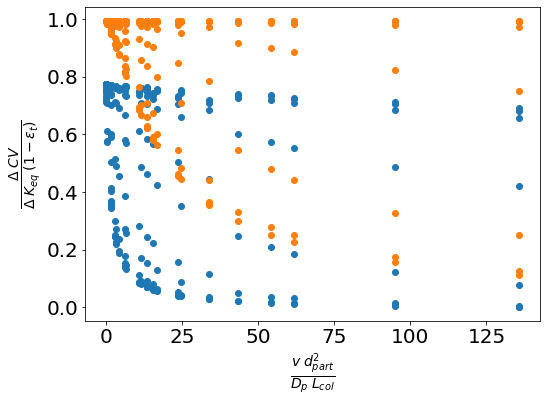

In [279]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{p} \; L_{col}}$')
ax.plot(df['yam_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')

# ax.set_xlim(0, 100)
# ax.set_ylim(0, 1)
explor.set_layout(fig, ax)
fig.savefig((image_folder / 'Ds_vs_Dp_1_reconciliation_1_b_reference.png').as_posix(), dpi=300)

**What if I use Ds in place of Dp?**

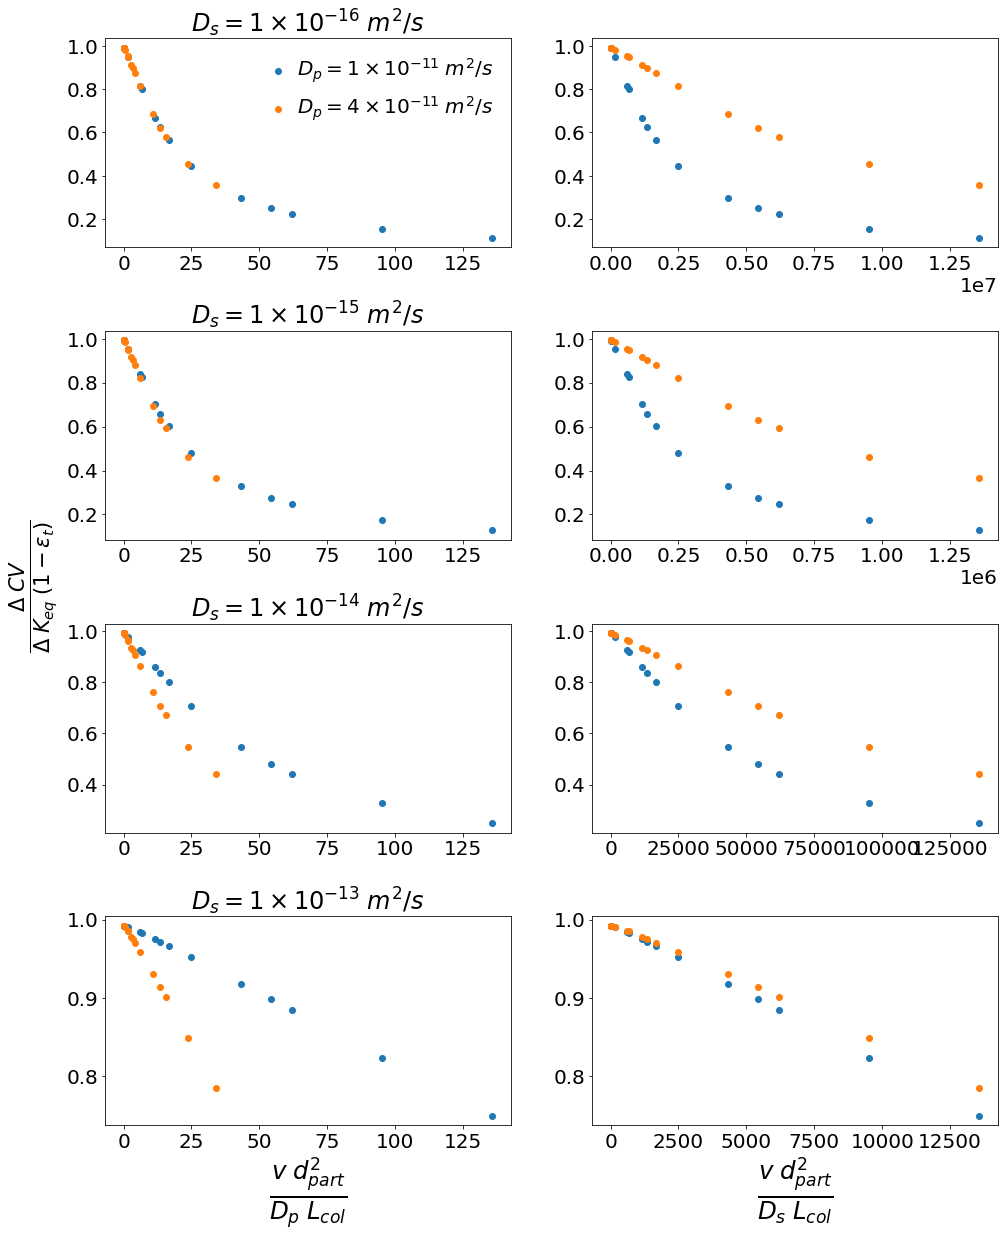

In [184]:
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(16, 20, forward=True)
font = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)

fig.text(0.04, 0.5, r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$', va='center', rotation='vertical', fontsize=30)
ax[3,0].set_xlabel(r'$\frac{v \; d_{part}^2}{D_p \; L_{col}}$', fontsize=35)
ax[3,1].set_xlabel(r'$\frac{v \; d_{part}^2}{D_s \; L_{col}}$', fontsize=35)

for i, Ds in enumerate(Ds_vals[:int(len(Ds_vals)/2)]):
# for i, Ds in enumerate(Ds_vals[int(len(Ds_vals)/2):]):
    df_temp = df[(df.Ds == Ds)]
    
    for Dp in Dp_vals:
        df_sub = df_temp[df_temp.Dp == Dp]
        ax[i,0].scatter(df_sub.yam_x, df_sub['0.50']/(1.0-eps_t), label = fr'$D_p = {as_si(Dp, 0):s} \; m^2/s$')
        ax[i,1].scatter(df_sub.alt_x, df_sub['0.50']/(1.0-eps_t), label = fr'$D_p = {as_si(Dp, 0):s} \; m^2/s$')
        
        ax[i,0].set_title(fr'$D_s = {as_si(Ds, 0):s} \; m^2/s$')

ax[0,0].legend(loc='best', handlelength=0.3, frameon=False)
# ax[0,0].set_ylim(0, 1)
fig.subplots_adjust(hspace=0.4)
fig.patch.set_alpha(1)
fig.savefig((image_folder / 'Ds_vs_Dp_1.png').as_posix(), dpi=150)
# fig.savefig((image_folder / 'Ds_vs_Dp_2.png').as_posix(), dpi=150)

**Could I combine Ds and Dp in a more general transport term?**

Needs to obey limits and reflect the balance between Dp and Ds

First model below


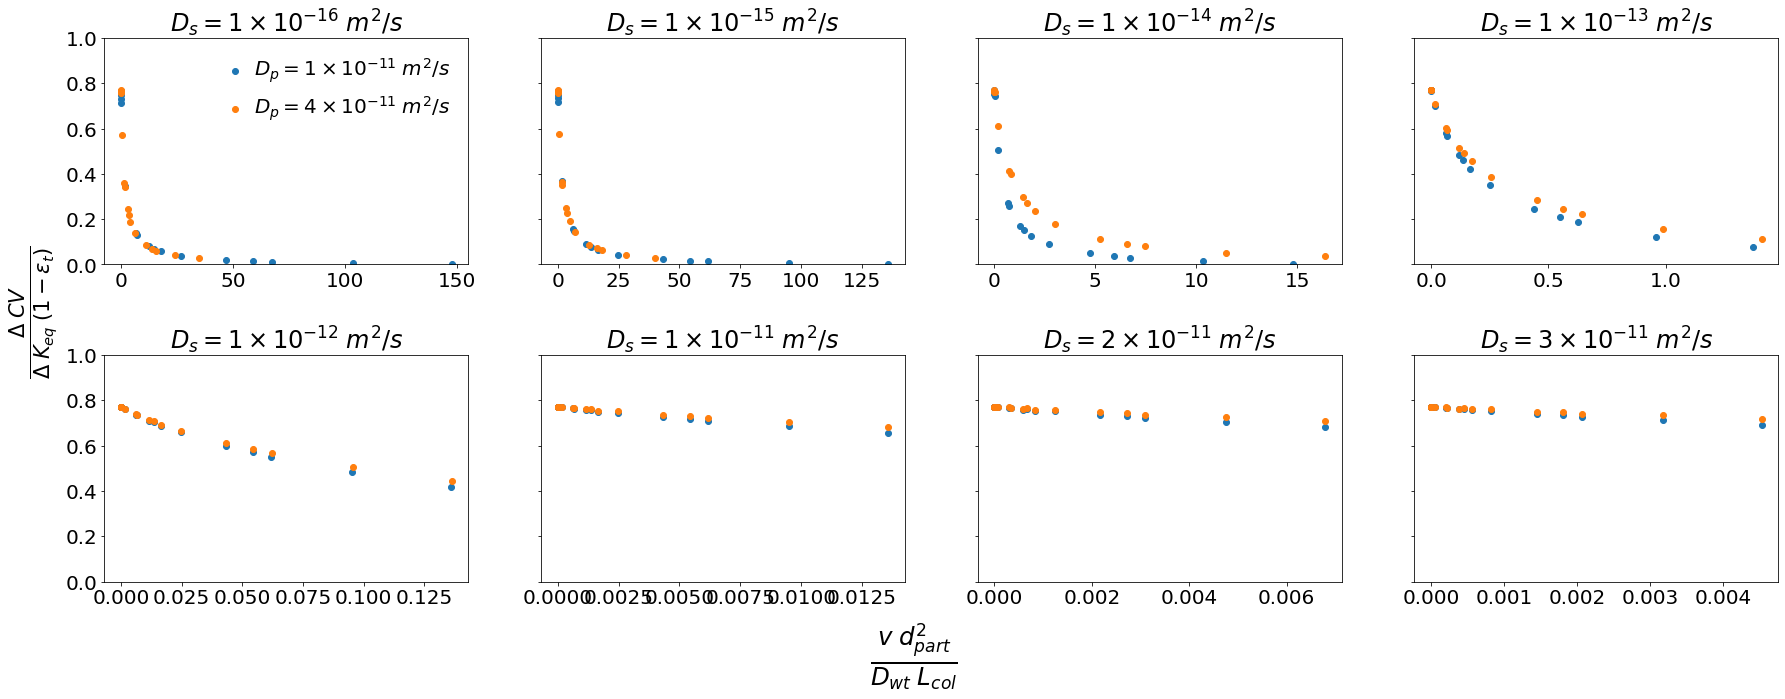

In [267]:
w1 = 1.0e4
w2 = 1.0e0

df['D_combo'] = ((w1*df['Ds'])**2 + (w2*df['Dp'])**2)/(w1*df['Ds'] + w2*df['Dp'])
df['new_x'] = (df['v'] * df['d_part']**2) / (df['D_combo'] * df['l_col'])

fig, ax = plt.subplots(2, 4, sharey=True)
fig.set_size_inches(30, 10, forward=True)
font = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)

fig.text(0.08, 0.5, r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$', va='center', rotation='vertical', fontsize=30)
fig.text(0.5, 0.00, r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$', ha='center', fontsize=35)

for i, Ds in enumerate(Ds_vals):
    if i > 3:
        row = 1
        i -= 4
    else:
        row = 0
    ax[row, i].set_title(fr'$D_s = {as_si(Ds, 0):s} \; m^2/s$')

    df_temp = df[(df.Ds == Ds)]
    for Dp in Dp_vals:
        df_sub = df_temp[df_temp.Dp == Dp]
        ax[row, i].scatter(df_sub.new_x, df_sub['0.01']/(1.0-eps_t), label = fr'$D_p = {as_si(Dp, 0):s} \; m^2/s$')
    
ax[0,0].legend(loc='best', handlelength=0.3, frameon=False)
ax[0,0].set_ylim(0, 1)
fig.subplots_adjust(hspace=0.4)
fig.patch.set_alpha(1)
fig.savefig((image_folder / 'Ds_vs_Dp_1_reconciliation_1.png').as_posix(), dpi=150)
    

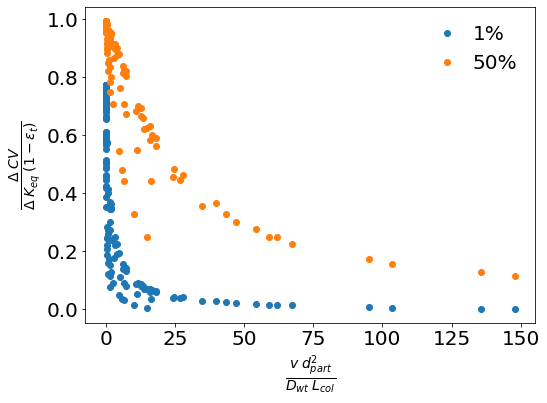

In [274]:
wt = 1.0e4
df['D_combo'] = ((wt*df['Ds'])**2 + df['Dp']**2)/(wt*df['Ds'] + df['Dp'])
df['new_x'] = (df['v'] * df['d_part']**2) / (df['D_combo'] * df['l_col'])

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')
ax.plot(df['new_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['new_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')

# ax.set_xlim(0, 100)
# ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'Ds_vs_Dp_1_reconciliation_1_b.png').as_posix(), dpi=300)

**Linear combination**

In [9]:
# res = optimize.minimize(get_residuals_2, x0=[4, 1], args=(df,))
# res

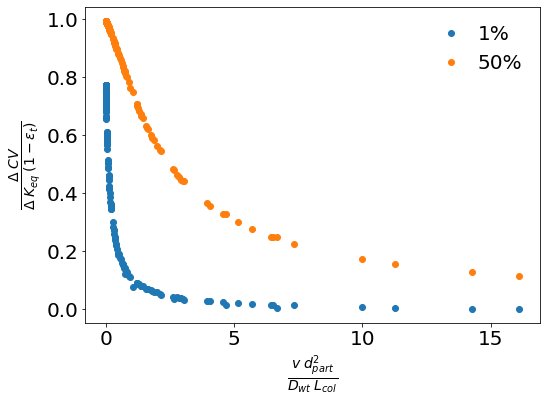

In [407]:
df = mod_x_2(res.x, df)

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')

ax.plot(df['new_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['new_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
fig.savefig((image_folder / 'Ds_vs_Dp_reconciliation_3.png').as_posix(), dpi=300)

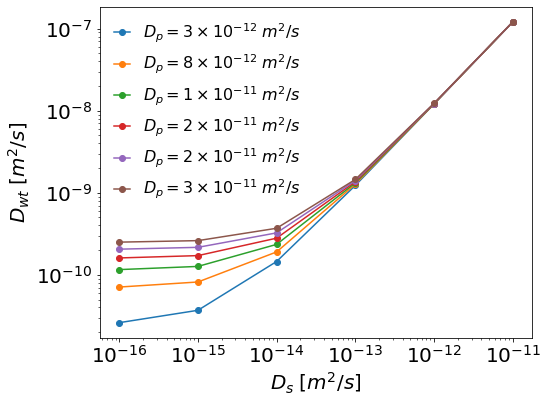

In [413]:
Dp_range = np.linspace(3.0e-12, 3.0e-11, 6)
Ds_range = np.logspace(-16, -11, 6)

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$D_{wt} \; [m^2/s]$')
ax.set_xlabel(r'$D_{s} \; [m^2/s]$')

for Dp in Dp_range:
    D_combo_vals = []
    for Ds in Ds_range:
        D_combo_vals.append(get_D_combo_2(res.x, Ds, Dp))
    
    ax.loglog(Ds_range, D_combo_vals, '-o', label=fr'$D_p = {as_si(Dp, 0):s} \; m^2/s$')

explor.set_layout(fig, ax, legend=True, fontsize=16)
fig.savefig((image_folder / 'D_combo_vs_Ds_reconciliation_3.png').as_posix(), dpi=300)

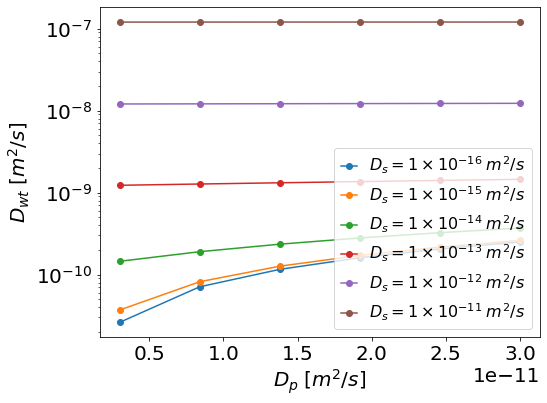

In [414]:
Dp_range = np.linspace(3.0e-12, 3.0e-11, 6)
Ds_range = np.logspace(-16, -11, 6)

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$D_{wt} \; [m^2/s]$')
ax.set_xlabel(r'$D_{p} \; [m^2/s]$')

for Ds in Ds_range:
    D_combo_vals = []
    for Dp in Dp_range:
        D_combo_vals.append(get_D_combo_2(res.x, Ds, Dp))
    
    ax.plot(Dp_range, D_combo_vals, '-o', label=fr'$D_s = {as_si(Ds, 0):s} \; m^2/s$')

ax.set_yscale('log')
ax.legend(loc='lower right', handlelength=1, fontsize=16)
explor.set_layout(fig, ax)
fig.savefig((image_folder / 'D_combo_vs_Dp_reconciliation_3.png').as_posix(), dpi=300)

In [41]:
e_vals = [4.08067821, 0.91932137]

# Does the linear combination of Dp and Ds explain yesterday's problem?
A:  yes

In [18]:
e_vals = [4.08067821, 0.91932137]

In [9]:
results_folder = Path().absolute() / 'sim_results_relevant_variable'
file_names = os.listdir(results_folder.as_posix())
files = [(file_name, results_folder) for file_name in file_names]

pool      = mp.Pool(processes = 10)
results   = pool.map(get_sim_data, files)
pool.close()
pool.join()

Q_1.1e-08_Dp_1.5e-11_dpart_5.0e-06_lcol_5.0e-02.h5
Q_6.5e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5
Q_1.1e-08_Dp_2.0e-12_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.6e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_2.0e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_7.0e-05_lcol_3.5e-01.h5
Q_6.5e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Q_1.6e-09_Dp_2.7e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_3.5e-01.h5
Q_1.1e-08_Dp_1.5e-11_dpart_1.4e-04_lcol_5.0e-02.h5
Q_1.1e-08_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5
Q_1.6e-08_Dp_2.0e-12_dpart_7.0e-05_lcol_3.5e-01.h5
Q_1.6e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_5.0e-02.h5
Q_1.1e-08_Dp_1.5e-11_dpart_2.0e-04_lcol_5.0e-01.h5
Q_1.6e-08_Dp_2.7e-11_dpart_2.0e-04_lcol_3.5e-01.h5
Q_1.6e-08_Dp_1.5e-11_dpart_2.0e-04_lcol_5.0e-01.h5Q_1.1e-08_Dp_2.7e-11_dpart_1.4e-04_lcol_2.0e-01.h5

Q_1.6e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5
Q_1.6e-09_Dp_2.0e-12_dpart_5.0e-06_lcol_5.0e-02.h5
Q_6.5e-09_Dp_1.5e-11_dpart_7.0e-05_lcol_2.0e-01.h5
Q_1.6e-08_Dp_1.5e-11_dpart_1.4e

In [19]:
d_col = 0.5e-2
area_col = np.pi/4 * d_col**2
fracs = np.arange(0.01, 0.81, 0.01)

columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds'] + [f'{i:.2f}' for i in fracs]
df = pd.DataFrame(results, columns=columns)
df['v'] = df['fVolum']/(eps_c * area_col)
df['pe'] = df['v'] * df['d_part'] / df['Dp']
df['yam_x'] = df['pe'] * df['d_part'] / df['l_col']

df = mod_x_2(e_vals, df)

Yesterday's plot, with Yamamoto's x

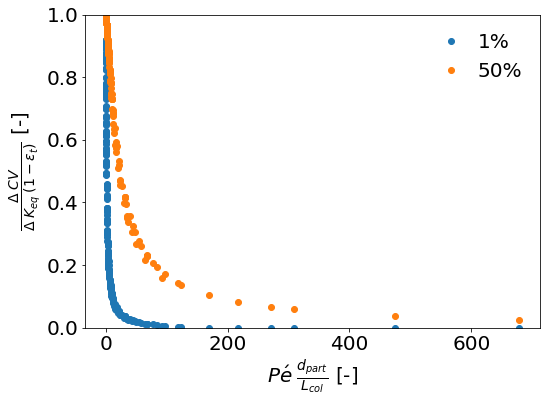

In [26]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$ [-]')
ax.set_xlabel(r'$P\'{e} \; \frac{d_{part}}{L_{col}}$ [-]')
ax.plot(df['yam_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['yam_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')

# ax.set_xlim(0, 100)
ax.set_ylim(0, 1)
explor.set_layout(fig, ax, legend=True)
# fig.savefig((image_folder / 'yam_x.png').as_posix(), dpi=300)

New plot, with $D_{wt}$

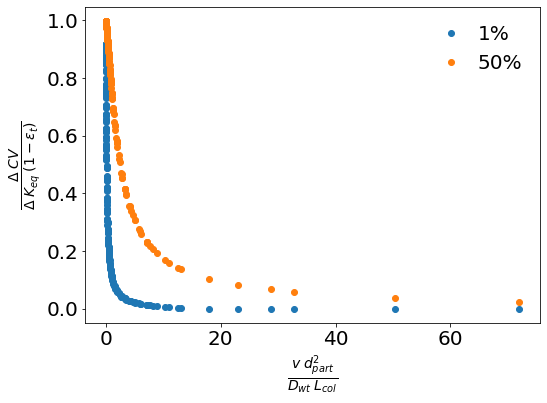

In [34]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')

ax.plot(df['new_x'], df['0.01']/(1.0-eps_t), 'o', label='1%')
ax.plot(df['new_x'], df['0.50']/(1.0-eps_t), 'o', label='50%')
# ax.plot(df['new_x'], df['0.80']/(1.0-eps_t), 'o', label='80%')

# ax.set_xlim(0, 20)
explor.set_layout(fig, ax, legend=True)
# fig.savefig((image_folder / 'relevant_variable_data_with_Dwt.png').as_posix(), dpi=300)

# Does $CV_{break}$ remain linear with $K_{eq}$ when $D_s = f(K_{eq})$ is non-negligible?

A:  No

In [49]:
# Note:  assuming intercept = eps_c isn't bad
# At worst, with Keq = 1000, this would introduce 0.07% error in
# the delta(CV)/delta(Keq) estimate

print(f'Max error = {(eps_t)/1000*100:.4f}%')

Max error = 0.0694%


## PNAS correlation

In [50]:
data = np.loadtxt('./PNAS_Ds_Keq_correlation/data.txt')
data = np.delete(data, -1, 0)
df_pnas = pd.DataFrame(data, columns=['ln_keq', 'Ds'])
df_pnas['keq'] = np.exp(df_pnas['ln_keq'])
df_pnas['Ds'] *= 1.0e-12
df_pnas

,ln_keq,Ds,keq
0,1.782,4.910600e-12,5.941728e+00
1,2.154,2.276400e-12,8.619267e+00
2,2.896,9.756000e-13,1.810159e+01
3,3.995,6.829000e-13,5.432584e+01
4,5.255,4.228000e-13,1.915215e+02
5,7.311,2.276000e-13,1.496673e+03
6,13.971,6.500000e-14,1.168230e+06


In [51]:
df_temp = df_pnas[df_pnas.keq > 10]
res = optimize.curve_fit(corr.my_fit_function_ds, df_temp['keq'], 
                         np.log(df_temp['Ds']), p0=(np.exp(-11), -1.5))
a_pnas = res[0][0]
b_pnas = res[0][1]

keq_vals_pnas = np.logspace(np.log10(df_pnas.keq.min()), np.log10(df_pnas.keq.max()), 3)
ds_vals_pnas  = np.array([explor.get_ds(keq, a_pnas, b_pnas) for keq in keq_vals_pnas])

In [52]:
data = np.loadtxt('./PNAS_Ds_Keq_correlation/data_D.txt')
df_pnas_d = pd.DataFrame(data, columns=['ln_keq', 'Ds'])
df_pnas_d['keq'] = np.exp(df_pnas_d['ln_keq'])
df_pnas_d['Ds'] *= 1.0e-13


## Previous Ds correlation (my data)

In [53]:
resin  = 'phq'
keq_fit_params, Ds_fit_params = corr.get_correlation(resin)
Ds_fit_params = np.array(Ds_fit_params)

a = np.mean(np.array([Ds_fit_params[i, 0] for i in range(3)]))
b = np.mean(np.array([Ds_fit_params[i, 1] for i in range(3)]))

/home/chase/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


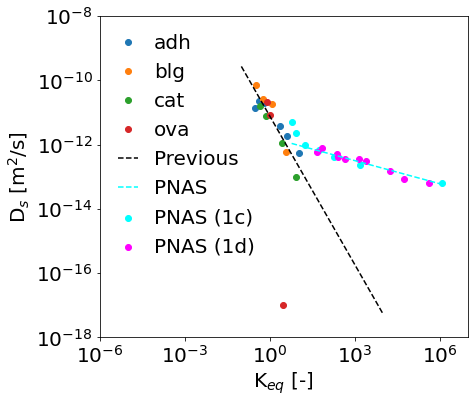

In [54]:
keq_vals = np.logspace(-1, 4, 3)
ds_vals  = np.array([explor.get_ds(keq, a, b) for keq in keq_vals])

fig, ax = plt.subplots()
corr.plot_ds(resin, fig, ax)
ax.plot(keq_vals, ds_vals, 'k--', label='Previous')

ax.scatter(df_pnas.keq, df_pnas.Ds, color='cyan', label='PNAS (1c)')
ax.scatter(df_pnas_d.keq, df_pnas_d.Ds, color='magenta', label='PNAS (1d)')
ax.plot(keq_vals_pnas, ds_vals_pnas, '--', color='cyan', label='PNAS')


ax.legend(loc='upper left', frameon=False, handlelength=1.0)
ax.set_xlim(1e-6, 1e7)
explor.set_layout(fig, ax)
# fig.savefig('./images_dispersion_terms/Ds_correlation.png', dpi=200)

## Simulations with the PNAS $D_s$ correlation

In [55]:
results_folder = Path().absolute() / 'sim_results_larger_Ds'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
images_folder = './images_dispersion_terms/'

In [56]:
eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

c_load = 2.0e-5

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

l_col  = 5.0e-2
fVolum = 1.633e-8/2

d_part_vals = np.array([50.0e-6, 100.0e-6])
Dp_vals     = np.linspace(2.0e-12, 4.0e-11, 3)
keq_vals    = np.linspace(0.01, 0.81, 5) # np.logspace(0, 4, 50)

In [20]:
## With multiprocessing
args_list = []

for Dp in Dp_vals:
    for d_part in d_part_vals:
        for keq in keq_vals:
            file_name = f'Dp_{Dp:.1e}_dpart_{d_part:.1e}_keq_{keq:.2e}.h5'
            res_file = os.path.join(results_folder, file_name)

            V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
            t_max = 4.5*V_col/fVolum*(keq*(1-eps_t) + eps_t) + 5000
            ka    = explor.get_ka(keq, q_max)
            
            Ds = explor.get_ds(keq, a_pnas, b_pnas) 
            
            sim = cad_utils.get_more_general_system(load_c=c_load, 
                    Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max,
                    use_linear=False, fVolumetric=fVolum, d_part=d_part,
                    l_col=l_col)

            args = (sim, res_file)
            args_list.append(args)

In [21]:
pool      = mp.Pool(processes = mp.cpu_count())
results   = pool.map(local_run_sim_fun, args_list)
pool.close()
pool.join()

/Dp_2.0e-12_dpart_5.0e-05_keq_1.00e-02.h5/Dp_2.0e-12_dpart_5.0e-05_keq_2.10e-01.h5

/Dp_2.0e-12_dpart_5.0e-05_keq_8.10e-01.h5/Dp_2.0e-12_dpart_5.0e-05_keq_4.10e-01.h5/Dp_2.0e-12_dpart_5.0e-05_keq_6.10e-01.h5
/Dp_2.0e-12_dpart_1.0e-04_keq_1.00e-02.h5
/Dp_2.1e-11_dpart_5.0e-05_keq_4.10e-01.h5
/Dp_2.1e-11_dpart_5.0e-05_keq_1.00e-02.h5/Dp_2.1e-11_dpart_5.0e-05_keq_6.10e-01.h5/Dp_2.1e-11_dpart_5.0e-05_keq_8.10e-01.h5/Dp_2.1e-11_dpart_5.0e-05_keq_2.10e-01.h5



/Dp_2.1e-11_dpart_1.0e-04_keq_1.00e-02.h5

/Dp_4.0e-11_dpart_5.0e-05_keq_1.00e-02.h5/Dp_2.1e-11_dpart_1.0e-04_keq_6.10e-01.h5/Dp_2.1e-11_dpart_1.0e-04_keq_2.10e-01.h5/Dp_2.1e-11_dpart_1.0e-04_keq_4.10e-01.h5
/Dp_2.1e-11_dpart_1.0e-04_keq_8.10e-01.h5/Dp_4.0e-11_dpart_5.0e-05_keq_2.10e-01.h5

/Dp_4.0e-11_dpart_5.0e-05_keq_6.10e-01.h5
/Dp_4.0e-11_dpart_5.0e-05_keq_8.10e-01.h5
/Dp_4.0e-11_dpart_1.0e-04_keq_2.10e-01.h5/Dp_4.0e-11_dpart_1.0e-04_keq_1.00e-02.h5


/Dp_4.0e-11_dpart_5.0e-05_keq_4.10e-01.h5
/Dp_4.0e-11_dpart_1.0e-04_keq_6.10e-0

### Load data
i.e. load CV_break directly, not the slope

In [57]:
files = []

for Dp in Dp_vals:
    for d_part in d_part_vals:
        for keq in np.concatenate((np.linspace(0.01, 0.81, 5), np.logspace(0, 4, 50))):
            file_name = f'Dp_{Dp:.1e}_dpart_{d_part:.1e}_keq_{keq:.2e}.h5'
            files.append((file_name, results_folder))

pool      = mp.Pool(processes = 5)
results   = pool.map(get_sim_data_keq, files)
pool.close()
pool.join()

In [58]:
fracs = np.arange(0.01, 0.81, 0.01)

columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds', 'keq'] + [f'{i:.2f}' for i in fracs]
df = pd.DataFrame(results, columns=columns)
df['v'] = df['fVolum']/(eps_c * area_col)
df = mod_x_2(e_vals, df)

### Plots to assess linearity

In [59]:
get_cv_ideal = lambda eps_t, Keq: eps_t + Keq*(1.0 - eps_t)

keq_exreme = [min(df['keq']), max(df['keq'])]
keq_vals = np.concatenate((np.linspace(keq_exreme[0], 10, 1000), np.linspace(10, keq_exreme[1], 3000)))
cv_ideal = [get_cv_ideal(eps_t, keq) for keq in keq_vals]
cv_min = eps_c

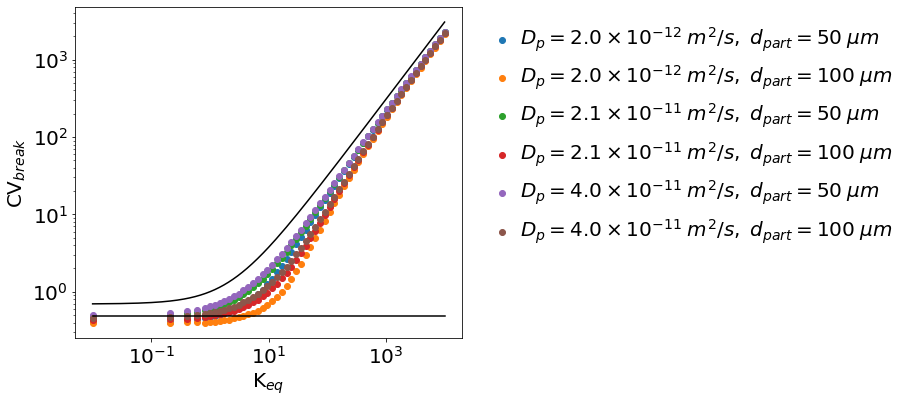

In [65]:
fig, ax = explor.instantiate_fig(13, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel(r'K$_{eq}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(keq_vals, cv_ideal, color='black')
ax.plot(keq_exreme, [cv_min, cv_min], color='black')

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)]
        ax.scatter(df_temp['keq'], df_temp['0.01'], 
                   label=f'$D_p = {as_si(Dp, 1):s} \; m^2/s, \; d_{{part}} = {d_part*1e6:.0f} \; \mu m$')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)
explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearity_of_CV_break_with_Keq_log.png', dpi=200)

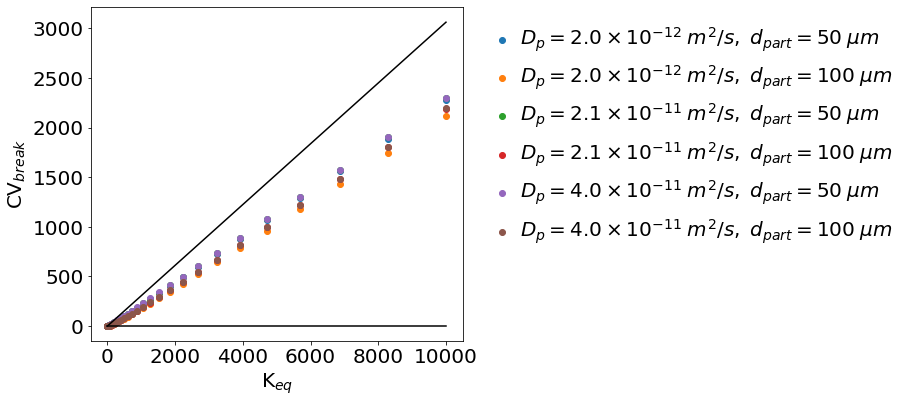

In [66]:
fig, ax = explor.instantiate_fig(13, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel(r'K$_{eq}$')

ax.plot(keq_vals, cv_ideal, color='black')
ax.plot(keq_exreme, [cv_min, cv_min], color='black')

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)]
        ax.scatter(df_temp['keq'], df_temp['0.01'], 
                   label=f'$D_p = {as_si(Dp, 1):s} \; m^2/s, \; d_{{part}} = {d_part*1e6:.0f} \; \mu m$')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)
explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearity_of_CV_break_with_Keq_linear.png', dpi=200)

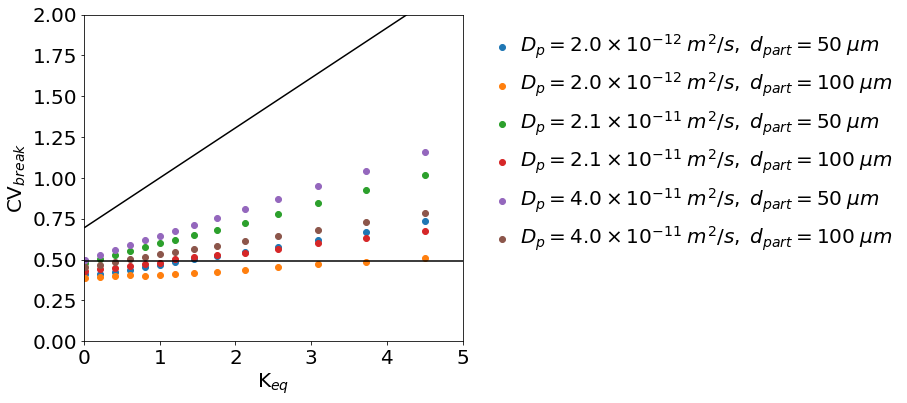

In [67]:
fig, ax = explor.instantiate_fig(13, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel(r'K$_{eq}$')
ax.set_xlim(0, 5)
ax.set_ylim(0, 2)

ax.plot(keq_vals, cv_ideal, color='black')
ax.plot(keq_exreme, [cv_min, cv_min], color='black')

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)]
        ax.scatter(df_temp['keq'], df_temp['0.01'], 
                   label=f'$D_p = {as_si(Dp, 1):s} \; m^2/s, \; d_{{part}} = {d_part*1e6:.0f} \; \mu m$')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)
explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearity_of_CV_break_with_Keq_zoomed.png', dpi=200)

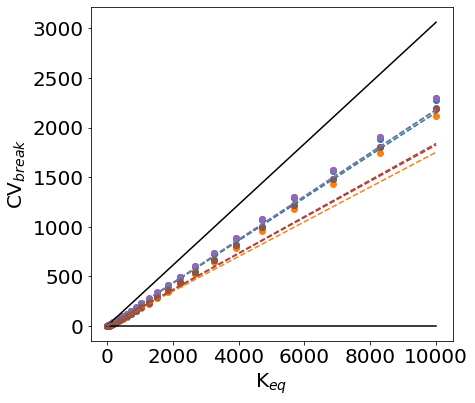

In [171]:
fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel(r'K$_{eq}$')
# ax.set_xlim(0, 1300)
# ax.set_ylim(0, 250)

ax.plot(keq_vals, cv_ideal, color='black')
ax.plot(keq_exreme, [cv_min, cv_min], color='black')

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)].copy()
        df_temp.sort_values(by=['keq'], inplace=True)
        df_temp.reset_index(inplace=True, drop=True)
        
        ax.scatter(df_temp['keq'], df_temp['0.01'], 
                   label=f'$D_p = {as_si(Dp, 1):s} \; m^2/s, \; d_{{part}} = {d_part*1e6:.0f} \; \mu m$')
        
        x_vals = [0, 1048]
        cv_vals = []
        for x in x_vals:
            if x == 0:
                cv_vals.append(eps_c)
            else:
                cv_vals.append(df_temp.loc[abs(df_temp['keq'] - x) < 1, '0.01'].iloc[0])
        
        p = np.poly1d(np.polyfit(x_vals, cv_vals, 1))
        ax.plot(df_temp['keq'], p(df_temp['keq']), '--' )

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)
explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearity_of_CV_break_with_Keq_linearity_check_zoomed_out.png', dpi=200)

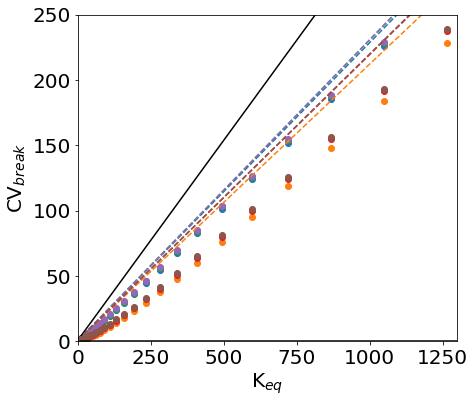

In [229]:
fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel(r'K$_{eq}$')
ax.set_xlim(0, 1300)
ax.set_ylim(0, 250)

ax.plot(keq_vals, cv_ideal, color='black')
ax.plot(keq_exreme, [cv_min, cv_min], color='black')

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)].copy()
        df_temp.sort_values(by=['keq'], inplace=True)
        df_temp.reset_index(inplace=True, drop=True)
        
        ax.scatter(df_temp['keq'], df_temp['0.01'], 
                   label=f'$D_p = {as_si(Dp, 1):s} \; m^2/s, \; d_{{part}} = {d_part*1e6:.0f} \; \mu m$')
        
        x_vals = [0, 10000]
        cv_vals = []
        for x in x_vals:
            if x == 0:
                cv_vals.append(eps_c)
            else:
                cv_vals.append(df_temp.loc[abs(df_temp['keq'] - x) < 1, '0.01'].iloc[0])
        
        p = np.poly1d(np.polyfit(x_vals, cv_vals, 1))
        ax.plot(df_temp['keq'], p(df_temp['keq']), '--' )

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handlelength=0.2, frameon=False)
explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearity_of_CV_break_with_Keq_linearity_check_larger_keq_zoomed_in.png', dpi=200)

# Can I fit a more complex function of $K_{eq}$ to describe $CV_{break}$?

In [7]:
def get_cv_fun(params, df):
    ### f1 (almost as good as f2 but simpler)
    a, b = params
    df['keq_fun'] = df['keq'] + a * np.log(df['keq']) + b * np.log(df['keq'])**2 

    ### f2
#     a, b, c, d = params
#     x = df['Ds']/df['Dp']
#     df['keq_fun'] = df['keq'] + a * np.log(df['keq']) + b * np.log(df['keq'])**2 \
#                     + d * np.log(df['keq'])**3 + c * np.log(x)
    return df

def get_cv_fun_res_group(params, df, Dp_vals, d_part_vals):
    total = 0
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)].copy()
            df_temp = get_cv_fun(params, df_temp)
            res = np.polyfit(df_temp['keq_fun'].values, df_temp['0.01'].values, 1, full=True)[1][0]
            total += res
    return total

In [251]:
res = optimize.minimize(get_cv_fun_res_group, 
                        x0=[1, 1], 
                        args=(df, Dp_vals, d_part_vals,))
print(res)

      fun: 10634.558448255402
 hess_inv: array([[ 0.01969787, -0.00189454],
       [-0.00189454,  0.00029995]])
      jac: array([ 0.00646973, -0.01184082])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 129
      nit: 8
     njev: 39
   status: 2
  success: False
        x: array([-1.85169   , -2.50624765])


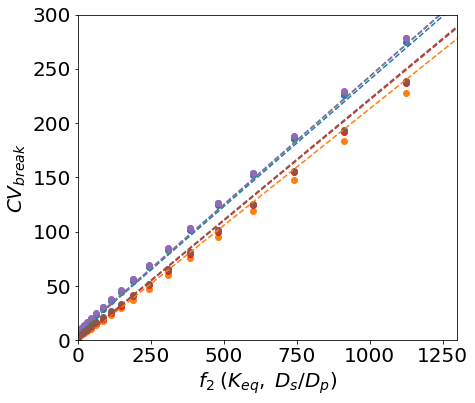

In [252]:
fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'$CV_{break}$')
ax.set_xlabel(r'$f_2 \; (K_{eq}, \; D_s/D_p)$')
ax.set_xlim(0, 1300)
ax.set_ylim(0, 300)

for Dp in Dp_vals:
    for d_part in d_part_vals:
        df_temp = df[(df.Dp == Dp) & (df.d_part == d_part)].copy()
        df_temp = get_cv_fun(res.x, df_temp)
                
        p = np.poly1d(np.polyfit(df_temp['keq_fun'], df_temp['0.01'], 1))
        ax.scatter(df_temp['keq_fun'], df_temp['0.01'])
        ax.plot(df_temp['keq_fun'], p(df_temp['keq_fun']), '--')

explor.set_layout(fig, ax)
# fig.savefig(images_folder + 'linearization_attempt_2.png', dpi=200)

## Could I fit $CV_{break}$ directly?
Note:  f2 below basically represents what I'm doing above, still trying to separate thermodynamic and transport contributions

In [60]:
df = mod_x_2(e_vals, df)
e_vals

[4.08067821, 0.91932137]

In [8]:
def get_rhs(params, eps_c, df):
    a, b, c, d, e1, e2 = params
    df = mod_x_2([e1, e2], df)
    
    ## f1
#     val = eps_c + df['keq'] * (c * df['new_x'] + d) + a*np.log(df['keq'])
    
    ## f2
    val = eps_c + (df['keq'] + a*np.log(df['keq']) + b*np.log(df['keq'])**2)\
                    * (c * df['new_x'] + d) 
    return val

def get_residual_keq_fun(params, eps_c, df):
    df['residual'] = df['0.01'] - get_rhs(params, eps_c, df.copy())
    return np.linalg.norm(df['residual'].values)

In [254]:
args=(eps_c, df)
bounds = [(-10.0, 10.0), (-5, 5), (-10.0, 0.0), (0.0, 1.0), (0.0, 10.0), 
          (0.0, 10.0)]
      
fit = optimize.differential_evolution(get_residual_keq_fun,
                                      bounds, args=args, disp=True, 
                                      workers=-1, updating='deferred', tol=1e-12)
fit

differential_evolution step 1: f(x)= 440.166
differential_evolution step 2: f(x)= 433.441
differential_evolution step 3: f(x)= 433.441
differential_evolution step 4: f(x)= 395.963
differential_evolution step 5: f(x)= 384.45
differential_evolution step 6: f(x)= 358.922
differential_evolution step 7: f(x)= 358.049
differential_evolution step 8: f(x)= 358.049
differential_evolution step 9: f(x)= 340.307
differential_evolution step 10: f(x)= 303.916
differential_evolution step 11: f(x)= 252.531
differential_evolution step 12: f(x)= 252.531
differential_evolution step 13: f(x)= 252.531
differential_evolution step 14: f(x)= 252.531
differential_evolution step 15: f(x)= 242.26
differential_evolution step 16: f(x)= 242.26
differential_evolution step 17: f(x)= 242.26
differential_evolution step 18: f(x)= 242.26
differential_evolution step 19: f(x)= 238.314
differential_evolution step 20: f(x)= 237.301
differential_evolution step 21: f(x)= 237.301
differential_evolution step 22: f(x)= 237.301
di

differential_evolution step 179: f(x)= 166.765
differential_evolution step 180: f(x)= 166.765
differential_evolution step 181: f(x)= 166.765
differential_evolution step 182: f(x)= 166.765
differential_evolution step 183: f(x)= 166.765
differential_evolution step 184: f(x)= 166.765
differential_evolution step 185: f(x)= 166.765
differential_evolution step 186: f(x)= 166.765
differential_evolution step 187: f(x)= 166.765
differential_evolution step 188: f(x)= 166.765
differential_evolution step 189: f(x)= 166.765
differential_evolution step 190: f(x)= 166.765
differential_evolution step 191: f(x)= 166.765
differential_evolution step 192: f(x)= 166.765
differential_evolution step 193: f(x)= 166.764
differential_evolution step 194: f(x)= 166.764
differential_evolution step 195: f(x)= 166.764
differential_evolution step 196: f(x)= 166.764
differential_evolution step 197: f(x)= 166.764
differential_evolution step 198: f(x)= 166.764
differential_evolution step 199: f(x)= 166.764
differential_

differential_evolution step 357: f(x)= 166.764
differential_evolution step 358: f(x)= 166.764
differential_evolution step 359: f(x)= 166.764
differential_evolution step 360: f(x)= 166.764
differential_evolution step 361: f(x)= 166.764
differential_evolution step 362: f(x)= 166.764
differential_evolution step 363: f(x)= 166.764
differential_evolution step 364: f(x)= 166.764
differential_evolution step 365: f(x)= 166.764
differential_evolution step 366: f(x)= 166.764
differential_evolution step 367: f(x)= 166.764
differential_evolution step 368: f(x)= 166.764
differential_evolution step 369: f(x)= 166.764
differential_evolution step 370: f(x)= 166.764
differential_evolution step 371: f(x)= 166.764
differential_evolution step 372: f(x)= 166.764
differential_evolution step 373: f(x)= 166.764
differential_evolution step 374: f(x)= 166.764
differential_evolution step 375: f(x)= 166.764
differential_evolution step 376: f(x)= 166.764
differential_evolution step 377: f(x)= 166.764
differential_

     fun: 166.7643822891245
     jac: array([ 5.68434186e-06, -1.98951967e-05, -1.70530256e-05,  4.64240202e-02,
        3.69482225e-05, -6.53699321e-05])
 message: 'Optimization terminated successfully.'
    nfev: 34914
     nit: 386
 success: True
       x: array([ 0.65754434, -3.00370611, -0.79648403,  0.24157361,  4.40780926,
        1.88353502])

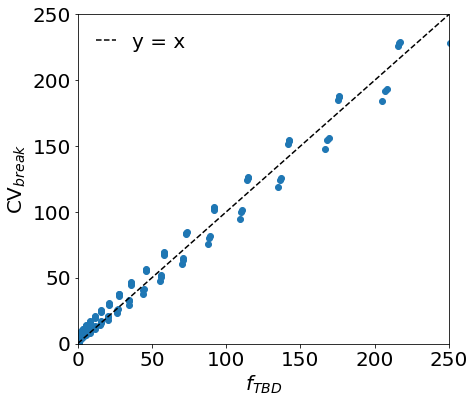

In [67]:
fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'CV$_{break}$')
ax.set_xlabel('$f_{TBD}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 250)

pts = [0, df['0.01'].max()]
ax.plot(pts, pts, 'k--', label='y = x')

ax.scatter(get_rhs([ 0.65754434, -3.00370611, -0.79648403,  0.24157361,  4.40780926,
        1.88353502], eps_c, df), df['0.01'])
           
explor.set_layout(fig, ax, legend=True)
fig.savefig(images_folder + 'direct_fit_attempt_2_zoomed.png', dpi=200)

## Preparation
### Literature $D_{ax}$ correlation

In [260]:
dax_data = np.loadtxt('./Dax_literature_correlation/Dax_correlation.txt')

In [261]:
dax_data

array([[0.421 , 0.3168],
       [3.9434, 4.638 ]])

In [266]:
np.polyfit(dax_data[:,0], dax_data[:,1], 1)

array([ 1.2267772, -0.1996732])

In [265]:
logy = np.poly1d(np.polyfit(dax_data[:,0], dax_data[:,1], 1)) # Input log10 of d_part * v/D * eps_c/(1-eps_c)
logy(2)

2.253881194640019

In [9]:
def get_Dax(d_part, fVolum, area_col, eps_c, D):
    logy_fun = np.poly1d([ 1.2267772, -0.1996732])
    x = d_part/D * fVolum/area_col * 1/(1-eps_c)
    logx = np.log10(x)
    logy = logy_fun(logx)
    Dax = D * 10.0**(logy)
    return Dax

def previous_fun(fVolum):
    return 5.0e-7*fVolum/1.633e-8

In [304]:
D = 1.15e-10
d_part = 9.0e-5

lysozyme_fits = np.array([[1.00000000e-01, 4.77130515e-08],
                         [3.00000000e-01, 3.25885235e-07],
                         [4.90000000e-01, 8.34428194e-07],
                         [7.00000000e-01, 1.38530924e-06],
                         [9.80000000e-01, 2.06417505e-06]])

lys_flow = lysozyme_fits[:,0] / (60*1e6) 
lys_dax  = lysozyme_fits[:,1] 

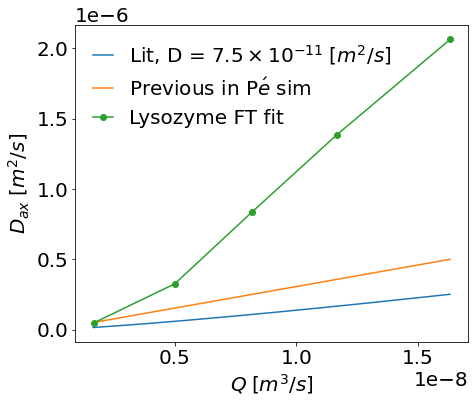

In [310]:
d_part = 50.0e-6
D = 7.5e-11 # representative free solution diffusivity for a mock protein

fVolum_vals = np.linspace(1.633e-9, 1.633e-8, 1000)
new_dax = [get_Dax(d_part, fVolum, area_col, eps_c, D) for fVolum in fVolum_vals]
pre_dax = [previous_fun(fVolum) for fVolum in fVolum_vals]

fig, ax = explor.instantiate_fig()
ax.set_xlabel(r'$Q \; [m^3/s]$')
ax.set_ylabel(r'$D_{ax} \; [m^2/s]$')

ax.plot(fVolum_vals, new_dax, label=fr'Lit, D = ${as_si(D,1):s} \; [m^2/s$]')
ax.plot(fVolum_vals, pre_dax, label=r'Previous in P$\'e$ sim')
ax.plot(lys_flow, lys_dax, label=r'Lysozyme FT fit', marker='o')

explor.set_layout(fig, ax, legend=True)
fig.savefig(images_folder + 'Dax_relationship.png', dpi=200)

# Comprehensive simulations
With relevant transport parameters examined thus far and the Keq range

In [8]:
results_folder = Path().absolute() / 'sim_results_more_comprehensive'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_more_comprehensive_sims'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

In [10]:
eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

In [11]:
fVolum_vals = np.linspace(1.633e-8/3, 1.633e-8*2/3, 3) # for d_c = 0.5 cm, corresponds to 100-200 cm/h
Dp_vals     = np.linspace(5.0e-12, 4.0e-11, 3)
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 4)
l_col_vals  = np.linspace(5.0e-2, 50.0e-2, 4)
# keq_vals    = np.concatenate((np.linspace(0.01, 0.81, 5), np.logspace(0, 4, 50), np.linspace(2e4, 2e4, 1)))
# load_c_vals = np.array([2.0e-5, 2.0e-4, 2.0e-3, 2.0e-2, 2.0e-1])

keq_vals = np.array([6.86648845e+03])
load_c_vals = np.array([2.0e-5])

In [12]:
def get_t_saturation(V_col, fVolum, eps_t, c_load, q_max):
    return V_col*(1-eps_t)*q_max/fVolum/c_load

def get_t_ILL(V_col, fVolum, eps_t, keq):
    return 4.5*V_col/fVolum*(keq*(1-eps_t) + eps_t)

def get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq):
    t_sat = get_t_saturation(V_col, fVolum, eps_t, c_load, q_max)
    t_ILL = get_t_ILL(V_col, fVolum, eps_t, keq)
    sim_t = min(t_sat, t_ILL)
    
    if sim_t < 5000 or sim_t == t_sat:
        pad = 500
    else:
        pad = 5000
    
    long_pad = 0.1*sim_t
    if long_pad > pad:
        pad = long_pad
    
    sim_t += pad
    return sim_t

## Run more comprehensive simulations
Next time write a script for running on the command line - this died at c_load = 2e-5 and keq = 6.87e3 (during the first run)

In [11]:
# ## Used for finishing the round that died -- use the block below for more sims
# files = os.listdir('./sim_results_more_comprehensive/')
# problems = []

# for c_load in load_c_vals:
#     for keq in keq_vals:    
#         for fVolum in fVolum_vals:
            
#             args_list = []
#             for Dp in Dp_vals:
#                 for d_part in d_part_vals:
#                     for l_col in l_col_vals:
#                         file_name = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
#                         try:
#                             results = get_sim_data_keq((file_name, results_folder))
#                         except:
#                             problems.append(file_name)
                        
#                         if file_name in problems or results[20] < 0.1:
#                             res_file = os.path.join(results_folder, file_name)

#                             V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
#                             t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
#                             ka    = explor.get_ka(keq, q_max)

#                             Ds = explor.get_ds(keq, a_pnas, b_pnas) 

#                             sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
#                                                                eps_c=eps_c, eps_p=eps_p)

#                             args = (sim, res_file)
#                             args_list.append(args)
            
#             if len(args_list) > 0:
#                 pool      = mp.Pool(processes = mp.cpu_count())
#                 results   = pool.map(local_run_sim_fun, args_list)
#                 pool.close()
#                 pool.join()

In [13]:
# ## With multiprocessing
# args_list = []

# for c_load in load_c_vals:
#     for keq in keq_vals:    
#         for fVolum in fVolum_vals:
            
#             args_list = []
#             for Dp in Dp_vals:
#                 for d_part in d_part_vals:
#                     for l_col in l_col_vals:
#                         file_name = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
#                         res_file = os.path.join(results_folder, file_name)

#                         V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
#                         t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
#                         ka    = explor.get_ka(keq, q_max)

#                         Ds = explor.get_ds(keq, a_pnas, b_pnas) 

#                         sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
#                                                            eps_c=eps_c, eps_p=eps_p)

#                         args = (sim, res_file)
#                         args_list.append(args)
                        
#             pool      = mp.Pool(processes = mp.cpu_count())
#             results   = pool.map(local_run_sim_fun, args_list)
#             pool.close()
#             pool.join()

## Load data
From first attempt

In [14]:
## With multiprocessing
fracs = np.arange(0.01, 0.81, 0.01)
columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds', 'keq'] + [f'{i:.2f}' for i in fracs]
e_vals = [4.08067821, 0.91932137]

files = os.listdir('./sim_results_more_comprehensive/')
keq_strings = [file[file.find('keq'):file.find('fVolum')] for file in files]
keq_strings = list(set(keq_strings))

for i, keq_str in enumerate(keq_strings):
    file_set = [(file, results_folder) for file in files if keq_str in file]
    pool     = mp.Pool(processes = 10)
    results  = pool.map(get_sim_data_keq, file_set)
    pool.close()
    pool.join()
        
    df_temp = pd.DataFrame(results, columns=columns)
    df_temp['v'] = df_temp['fVolum']/(eps_c * area_col)
    df_temp = mod_x_2(e_vals, df_temp)

    if i == 0:
        df = df_temp.copy()
    else:
        df = pd.concat([df, df_temp], ignore_index=True)
    print(i, keq_str)

0 keq_6.10e-01_
1 keq_7.20e+02_
2 keq_2.95e+01_
3 keq_1.60e+02_
4 keq_5.43e+00_
5 keq_4.50e+00_
6 keq_5.18e+01_
7 keq_3.73e+00_
8 keq_2.10e-01_
9 keq_1.10e+02_
10 keq_1.26e+03_
11 keq_6.87e+03_
12 keq_2.56e+00_
13 keq_4.29e+01_
14 keq_3.91e+03_
15 keq_1.68e+01_
16 keq_6.55e+00_
17 keq_3.56e+01_
18 keq_8.10e-01_
19 keq_4.10e-01_
20 keq_5.96e+02_
21 keq_4.71e+03_
22 keq_2.33e+02_
23 keq_1.00e+00_
24 keq_5.69e+03_
25 keq_9.10e+01_
26 keq_1.93e+02_
27 keq_6.25e+01_
28 keq_2.12e+00_
29 keq_1.46e+00_
30 keq_1.53e+03_
31 keq_7.91e+00_
32 keq_3.24e+03_
33 keq_1.33e+02_
34 keq_1.21e+00_
35 keq_1.76e+00_
36 keq_9.54e+00_
37 keq_2.81e+02_
38 keq_1.00e-02_
39 keq_3.09e+00_
40 keq_4.94e+02_
41 keq_8.69e+02_
42 keq_4.09e+02_
43 keq_2.68e+03_
44 keq_1.05e+03_
45 keq_1.15e+01_
46 keq_2.44e+01_
47 keq_1.39e+01_
48 keq_2.22e+03_
49 keq_1.84e+03_
50 keq_7.54e+01_
51 keq_3.39e+02_
52 keq_2.02e+01_


In [15]:
# df.to_csv('./comprehensive_results_1.csv', index=False)

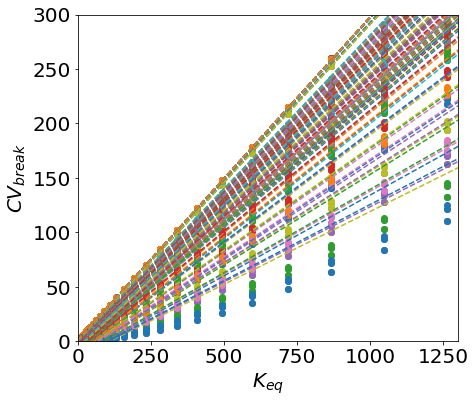

In [51]:
df = pd.read_csv('./comprehensive_results_1.csv')

fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'$CV_{break}$')
ax.set_xlabel(r'$K_{eq}$')
# ax.set_xlabel(r'$f_1 \; (K_{eq})$')
ax.set_xlim(0, 1300)
ax.set_ylim(0, 300)

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp = df[(df.Dp - Dp < 1e-13) & (df.d_part == d_part) \
                                & (df.l_col == l_col) & (df.fVolum == fVolum)].copy()
                
#                 df_temp = get_cv_fun([0.65754434, -3.00370611], df_temp)
                df_temp = get_cv_fun([0, 0], df_temp)
                ax.scatter(df_temp['keq_fun'], df_temp['0.01'])

                df_temp.sort_values(by='keq_fun', inplace=True)
                p = np.poly1d(np.polyfit(df_temp['keq_fun'], df_temp['0.01'], 1))
                ax.plot(df_temp['keq_fun'], p(df_temp['keq_fun']), '--')

explor.set_layout(fig, ax)
fig.savefig('./images_more_comprehensive_sims/linearity_problem_zoomed.png', 
            dpi=200)

## Attempted correlation of comprehensive data (at $c_{load}$ = 2.0e-5)

In [11]:
def get_cv_fun(params, df):
    a, b = params
    df['keq_fun'] = df['keq'] + a * np.log(df['keq']) + b * np.log(df['keq'])**2 
    return df

def get_res(all_params):
    params, df = all_params
    df = get_cv_fun(params, df)
    df.sort_values(by='keq_fun', inplace=True)
    res = np.polyfit(df['keq_fun'].values, df['0.01'].values, 1, full=True)[1][0]
    return res
    
def get_cv_fun_res_group_2(params, dfs_list):
    all_params_list = [(params, df.copy()) for df in dfs_list]
    pool      = mp.Pool(processes = mp.cpu_count())
    results   = pool.map(get_res, all_params_list)
    pool.close()
    pool.join()
    return np.array(results).sum()

In [13]:
df = pd.read_csv('./comprehensive_results_1.csv')
dfs_list = []
for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp = df[(df.Dp - Dp < 1e-13) & (df.d_part == d_part) \
                                & (df.l_col == l_col) & (df.fVolum == fVolum)].copy()
                dfs_list.append(df_temp)

# # fit = optimize.minimize(get_cv_fun_res_group_2, x0=[1, 1], args=(dfs_list,))

# bounds = [(0.0, 10.0), (0.0, 10.0)]
# fit = optimize.differential_evolution(get_cv_fun_res_group_2,
#                                       bounds, args=(dfs_list,), disp=True, 
#                                       workers=1, updating='deferred', tol=1e-12)
# fit

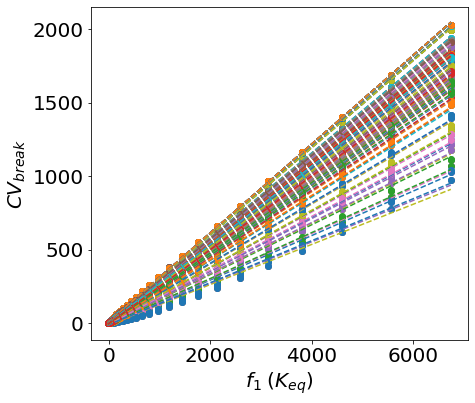

In [29]:
df = pd.read_csv('./comprehensive_results_1.csv')
params = [-1.27139371, -1.4010829]

fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'$CV_{break}$')
ax.set_xlabel(r'$f_1 \; (K_{eq})$')
# ax.set_xlim(0, 1300)
# ax.set_ylim(0, 300)

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp = df[(df.Dp - Dp < 1e-13) & (df.d_part == d_part) \
                            & (df.l_col == l_col) & (df.fVolum == fVolum)].copy()
                
                df_temp = get_cv_fun(params, df_temp)
                ax.scatter(df_temp['keq_fun'], df_temp['0.01'])

                df_temp.sort_values(by='keq_fun', inplace=True)
                p = np.poly1d(np.polyfit(df_temp['keq_fun'], df_temp['0.01'], 1))
                ax.plot(df_temp['keq_fun'], p(df_temp['keq_fun']), '--')

explor.set_layout(fig, ax)
# fig.savefig('./images_more_comprehensive_sims/linearity_problem_f1.png', 
#             dpi=200)

## With $D_{eff_p}$

In [13]:
df = pd.read_csv('./comprehensive_results_1.csv')

df['Dp_eff'] = df.Dp + (1.0 - eps_p)/eps_p * df.keq * df.Ds
df['new_x'] = (df['v'] * df['d_part']**2) / (df['Dp_eff'] * df['l_col'])

intercepts = {}
for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp = df[(df.Dp - Dp < 1e-16) & (df.d_part == d_part) \
                                & (df.l_col == l_col) & (df.fVolum == fVolum)].copy()
                key = f'fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}'
                intercepts[key] = df_temp.loc[df_temp.keq == 0.01, '0.01'].iloc[0]
                
for i, cont in df.iterrows():
    key = f'fVolum_{cont.fVolum:.1e}_Dp_{cont.Dp:.1e}_dpart_{cont.d_part:.1e}_lcol_{cont.l_col:.1e}'
    df.at[i, 'intercept'] = intercepts[key]

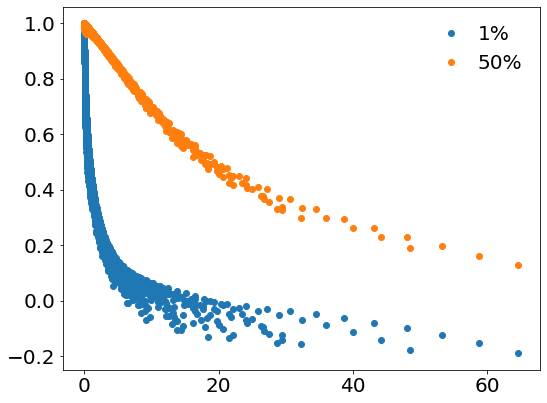

In [16]:
df_temp = df[df.keq > 5]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')


ax.plot(df_temp['new_x'], (df_temp['0.01']-eps_t)/((1.0-eps_t)*df_temp['keq']), 'o', label='1%')
ax.plot(df_temp['new_x'], (df_temp['0.50']-eps_t)/((1.0-eps_t)*df_temp['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)


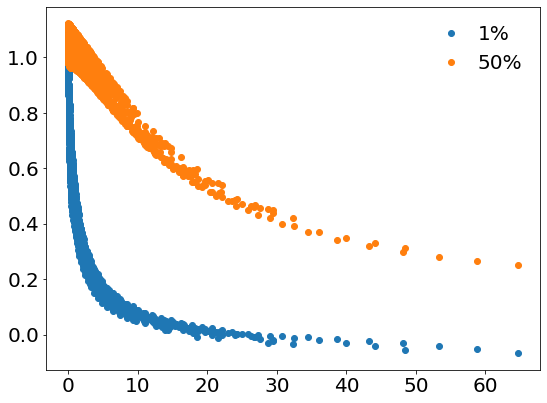

In [17]:
df_temp = df[df.keq > 5]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')


ax.plot(df_temp['new_x'], (df_temp['0.01']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='1%')
ax.plot(df_temp['new_x'], (df_temp['0.50']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)


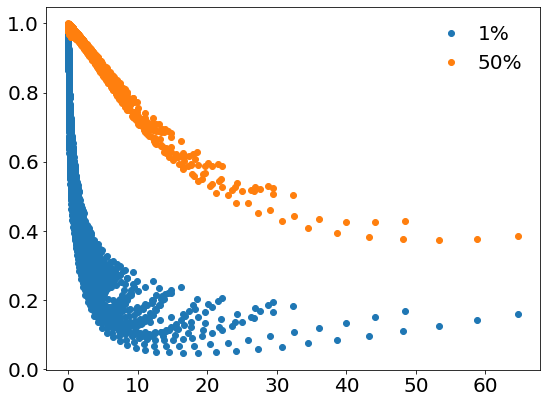

In [20]:
df_temp = df[df.keq > 5]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')


ax.plot(df_temp['new_x'], (df_temp['0.01'])/(eps_t + (1.0-eps_t)*df_temp['keq']), 'o', label='1%')
ax.plot(df_temp['new_x'], (df_temp['0.50'])/(eps_t + (1.0-eps_t)*df_temp['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)


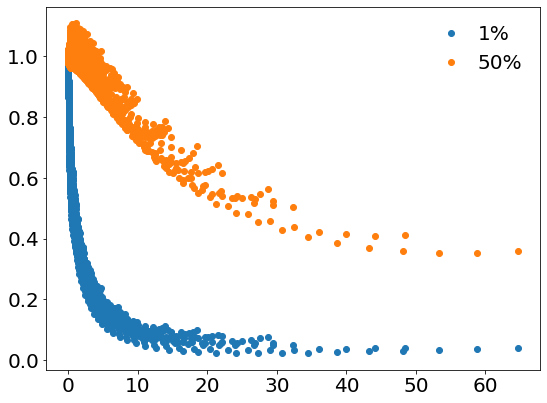

In [125]:
df_temp = df[df.keq > 5]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')


ax.plot(df_temp['new_x'], (df_temp['0.01']-df_temp.intercept)/((1.0-eps_t)*df_temp['keq']), 'o', label='1%')
ax.plot(df_temp['new_x'], (df_temp['0.50']-df_temp.intercept)/((1.0-eps_t)*df_temp['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)


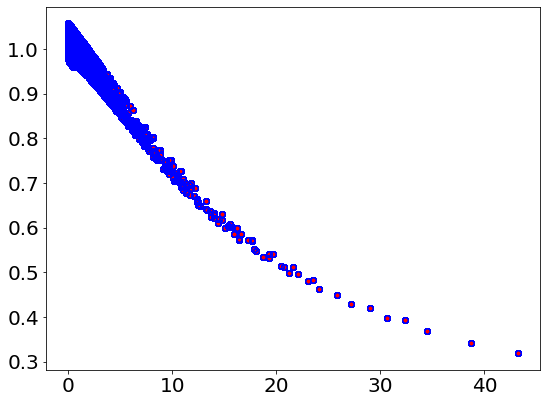

In [138]:
df_temp = df[df.keq > 10]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_t = df_temp[(df_temp.Dp - Dp < 1e-16) & (df_temp.d_part == d_part) \
                                & (df_temp.l_col == l_col) & (df_temp.fVolum == fVolum)].copy()
                if Dp < Dp_vals[1]:
                    color='red'
                    mfc='red'
                else:
                    color='blue'
                    mfc='none'
                ax.plot(df_temp['new_x'], (df_temp['0.50']-eps_c)/((1.0-eps_t)*df_temp['keq']), 
                        'o', color=color, mfc=mfc)

explor.set_layout(fig, ax)


## Comparison simulations with $D_p = D_{eff_p}$

In [21]:
df = pd.read_csv('./comprehensive_results_1.csv')
df['Dp_eff'] = df.Dp + (1.0 - eps_p)/eps_p * df.keq * df.Ds
df['new_x'] = (df['v'] * df['d_part']**2) / (df['Dp_eff'] * df['l_col'])

# fig, ax = explor.instantiate_fig()
# ax.hist(df.Dp_eff, 50)
# explor.set_layout(fig, ax)

In [22]:
fVolum_vals = np.linspace(1.633e-8/3, 1.633e-8*2/3, 2) # for d_c = 0.5 cm, corresponds to 100-200 cm/h
Dp_vals     = np.linspace(5.0e-12, 4.0e-11, 2)
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 2)
l_col_vals  = np.linspace(5.0e-2, 50.0e-2, 2)
# l_col_vals  = np.linspace(5.0e-2, 5.0e-2, 1)

# keq_vals    = np.array([1.00000000e+00, 9.54095476e+00, 1.09854114e+02])
keq_vals    = np.array([1.00000000e+1])

load_c_vals = np.array([2.0e-5])

In [23]:
## With multiprocessing
args_list = []

for c_load in load_c_vals:
    for keq in keq_vals:    
        for fVolum in fVolum_vals:
            for Dp in Dp_vals:
                for d_part in d_part_vals:
                    for l_col in l_col_vals:
                        
                        V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
                        t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
                        ka    = explor.get_ka(keq, q_max)

                        Ds = explor.get_ds(keq, a_pnas, b_pnas)
                        Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
                        Ds = 0.0
                        
#                         file_name = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
                        file_name = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
#                         file_name = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'
#                         file_name = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_check.h5'

                        res_file = os.path.join(results_folder, file_name)

#                         sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
#                                                            eps_c=eps_c, eps_p=eps_p)
                        sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp_eff, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
                                                           eps_c=eps_c, eps_p=eps_p)

                        args = (sim, res_file)
                        args_list.append(args)


In [24]:
pool      = mp.Pool(processes = mp.cpu_count()-2)
results   = pool.map(local_run_sim_fun, args_list)
pool.close()
pool.join()

/keq_1.00e+01_fVolum_5.4e-09_dpart_5.0e-06_lcol_5.0e-02_Dpeff_5.4e-11_higher_desc.h5
/keq_1.00e+01_fVolum_5.4e-09_dpart_2.0e-04_lcol_5.0e-01_Dpeff_5.4e-11_higher_desc.h5/keq_1.00e+01_fVolum_5.4e-09_dpart_5.0e-06_lcol_5.0e-01_Dpeff_5.4e-11_higher_desc.h5/keq_1.00e+01_fVolum_5.4e-09_dpart_2.0e-04_lcol_5.0e-02_Dpeff_5.4e-11_higher_desc.h5/keq_1.00e+01_fVolum_1.1e-08_dpart_5.0e-06_lcol_5.0e-02_Dpeff_1.9e-11_higher_desc.h5/keq_1.00e+01_fVolum_1.1e-08_dpart_5.0e-06_lcol_5.0e-01_Dpeff_1.9e-11_higher_desc.h5/keq_1.00e+01_fVolum_1.1e-08_dpart_2.0e-04_lcol_5.0e-02_Dpeff_1.9e-11_higher_desc.h5




/keq_1.00e+01_fVolum_1.1e-08_dpart_2.0e-04_lcol_5.0e-01_Dpeff_1.9e-11_higher_desc.h5/keq_1.00e+01_fVolum_1.1e-08_dpart_5.0e-06_lcol_5.0e-02_Dpeff_5.4e-11_higher_desc.h5
/keq_1.00e+01_fVolum_1.1e-08_dpart_2.0e-04_lcol_5.0e-02_Dpeff_5.4e-11_higher_desc.h5/keq_1.00e+01_fVolum_1.1e-08_dpart_5.0e-06_lcol_5.0e-01_Dpeff_5.4e-11_higher_desc.h5


/keq_1.00e+01_fVolum_1.1e-08_dpart_2.0e-04_lcol_5.0e-01_Dpeff_5.4e

In [32]:
dfs_Ds = {}
dfs_no_Ds = {}
dfs_no_Ds_better = {}
dfs_no_Ds_2 = {}
check = {}

for c_load in load_c_vals:
    for keq in [1, 10]:    
        for fVolum in fVolum_vals:
            for Dp in Dp_vals:
                for d_part in d_part_vals:
                    for l_col in l_col_vals:
                        Ds = explor.get_ds(keq, a_pnas, b_pnas)
                        Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
                        
#                         with_Ds = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
#                         no_Ds = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
                        no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
#                         no_Ds_2 = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'
                        check_key = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_check.h5'
                        
#                         try:
#                             dfs_Ds[with_Ds] = get_sim_data_2(results_folder, with_Ds)
#                         except:
#                             print(with_Ds)
                            
#                         try:
#                             dfs_no_Ds[no_Ds] = get_sim_data_2(results_folder, no_Ds)
#                         except:
#                             print(no_Ds)
                            
                        try:
                            dfs_no_Ds_better[no_Ds_better] = get_sim_data_2(results_folder, no_Ds_better)
                        except:
                            print(no_Ds_better)
                            
#                         try:
#                             dfs_no_Ds_2[no_Ds_2] = get_sim_data_2(results_folder, no_Ds_2)
#                         except:
#                             print(no_Ds_better)
                            
                        try:
                            check[check_key] = get_sim_data_2(results_folder, check_key)
                        except:
                            print(check)

In [33]:
len(dfs_no_Ds_better)

32

(-0.03, 0.05)

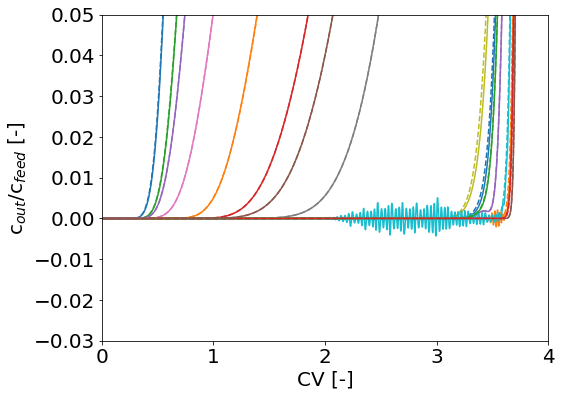

In [78]:
keq = 10
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

vals = []
cnt = 0
for c_load in load_c_vals:
    for fVolum in fVolum_vals:
        for Dp in Dp_vals:
            for d_part in d_part_vals:
                for l_col in l_col_vals:
                    vals.append(fVolum*d_part**2/(l_col*Dp))
                    Ds = explor.get_ds(keq, a_pnas, b_pnas)
                    Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds

                    no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
                    check_key = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_check.h5'
                    
                    if cnt==0:
                        ax.plot(dfs_no_Ds_better[no_Ds_better].CV, dfs_no_Ds_better[no_Ds_better].c_normal, label=r'$D_p=D_{eff_p}, \; D_s=0$') 
                        ax.plot(check[check_key].CV, check[check_key].c_normal, '--', color=plt.gca().lines[-1].get_color(), label=r'$D_p=D_p, \; D_s=D_s$') 
                    else:
                        ax.plot(dfs_no_Ds_better[no_Ds_better].CV, dfs_no_Ds_better[no_Ds_better].c_normal) 
                        ax.plot(check[check_key].CV, check[check_key].c_normal, '--', color=plt.gca().lines[-1].get_color()) 
                    cnt += 1

# ax.set_xlim(0, 10)
# ax.set_ylim(-0.05, 1.05)

# ax.set_xlim(3.5, 5)
# ax.set_ylim(0.85, 1.1)

ax.set_xlim(0, 4)
ax.set_ylim(-0.03, 0.05)

# explor.set_layout(fig, ax, legend=True, loc='upper left')
# fig.savefig('./images_more_comprehensive_sims/Deff_check_keq_10_all_top.png', dpi=200)

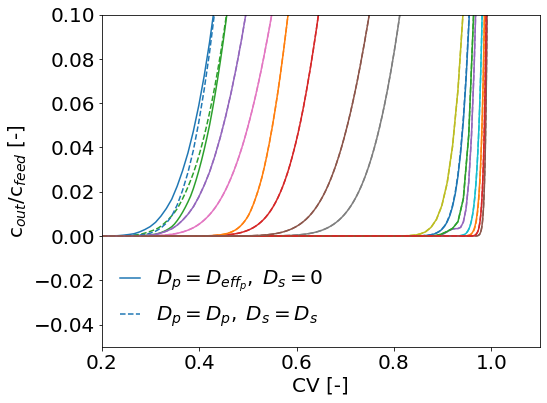

In [77]:
keq = 1
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

vals = []
cnt = 0
for c_load in load_c_vals:
    for fVolum in fVolum_vals:
        for Dp in Dp_vals:
            for d_part in d_part_vals:
                for l_col in l_col_vals:
                    vals.append(fVolum*d_part**2/(l_col*Dp))
                    Ds = explor.get_ds(keq, a_pnas, b_pnas)
                    Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds

                    no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
                    check_key = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_check.h5'

                    if cnt==0:
                        ax.plot(dfs_no_Ds_better[no_Ds_better].CV, dfs_no_Ds_better[no_Ds_better].c_normal, label=r'$D_p=D_{eff_p}, \; D_s=0$') 
                        ax.plot(check[check_key].CV, check[check_key].c_normal, '--', color=plt.gca().lines[-1].get_color(), label=r'$D_p=D_p, \; D_s=D_s$') 
                    else:
                        ax.plot(dfs_no_Ds_better[no_Ds_better].CV, dfs_no_Ds_better[no_Ds_better].c_normal) 
                        ax.plot(check[check_key].CV, check[check_key].c_normal, '--', color=plt.gca().lines[-1].get_color()) 
                    cnt += 1
                    
ax.set_xlim(0.2, 1.1)
ax.set_ylim(-0.05, 0.1)

# ax.set_xlim(0.9, 1.3)
# ax.set_ylim(0.8, 1.15)

# ax.set_xlim(0, 2.5)
# ax.set_ylim(-0.05, 1.15)

explor.set_layout(fig, ax, legend=True, loc='lower left')
fig.savefig('./images_more_comprehensive_sims/Deff_check_keq_1_all_bottom.png', dpi=200)

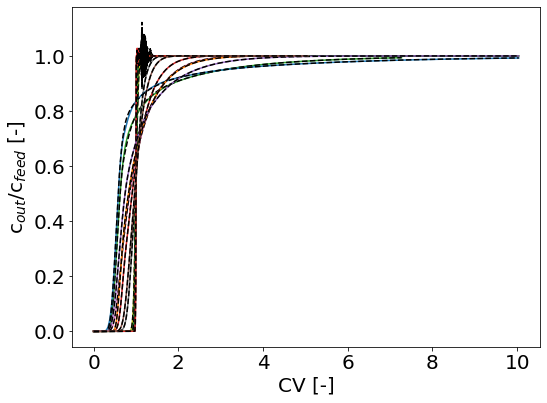

In [70]:
for keq in keq_vals:
    fig, ax = explor.instantiate_fig(8, 6)
    ax.set_xlabel('CV [-]')
    ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

    for c_load in load_c_vals:
        for fVolum in fVolum_vals:
            for Dp in Dp_vals:
                for d_part in d_part_vals:
                    for l_col in l_col_vals:
                        Ds = explor.get_ds(keq, a_pnas, b_pnas)
                        Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
                        
                        with_Ds = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                        no_Ds = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
                        no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
                        no_Ds_2 = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'
                        check_key = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_check.h5'
                        
#                         ax.plot(dfs_Ds[with_Ds].CV, dfs_Ds[with_Ds].c_normal)
#                         ax.plot(dfs_no_Ds[no_Ds].CV, dfs_no_Ds[no_Ds].c_normal, '--',
#                                color='black') # color=plt.gca().lines[-1].get_color())
                        ax.plot(dfs_no_Ds_better[no_Ds_better].CV, 
                                dfs_no_Ds_better[no_Ds_better].c_normal) 
#                         ax.plot(dfs_no_Ds_2[no_Ds_2].CV, 
#                                 dfs_no_Ds_2[no_Ds_2].c_normal, 
#                                color='magenta')

                        ax.plot(check[check_key].CV, 
                                check[check_key].c_normal, '--', color='black') 
    explor.set_layout(fig, ax)


In [68]:
# keq = keq_vals[1]

# fig, ax = explor.instantiate_fig(8, 6)
# ax.set_xlabel('CV [-]')
# ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

# for c_load in load_c_vals:
#     for fVolum in fVolum_vals:
#         for Dp in Dp_vals:
#             for d_part in d_part_vals:
#                 for l_col in l_col_vals:
#                     Ds = explor.get_ds(keq, a_pnas, b_pnas)
#                     Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds

#                     with_Ds = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
#                     no_Ds = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
#                     no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
#                     no_Ds_2 = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'

# #                     ax.plot(dfs_Ds[with_Ds].CV, dfs_Ds[with_Ds].c_normal)
#                     ax.plot(dfs_no_Ds[no_Ds].CV, dfs_no_Ds[no_Ds].c_normal, '--',
#                            color='black') # color=plt.gca().lines[-1].get_color())
#                     ax.plot(dfs_no_Ds_better[no_Ds_better].CV, 
#                             dfs_no_Ds_better[no_Ds_better].c_normal, ':',
#                            color='cyan') 
#                     ax.plot(dfs_no_Ds_2[no_Ds_2].CV, 
#                             dfs_no_Ds_2[no_Ds_2].c_normal, 
#                            color='magenta')

# ax.set_xlim(3, 4)
# ax.set_ylim(-0.1, 0.1)

# explor.set_layout(fig, ax)


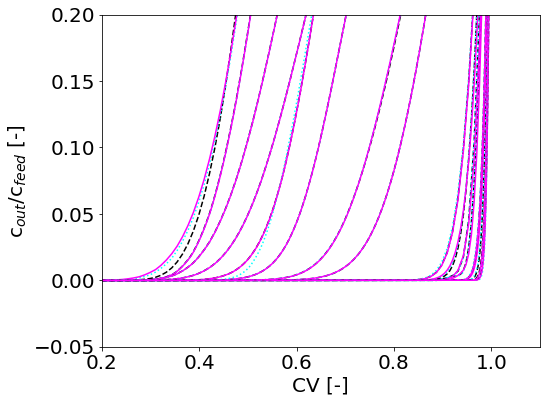

In [34]:
keq = keq_vals[0]

fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for c_load in load_c_vals:
    for fVolum in fVolum_vals:
        for Dp in Dp_vals:
            for d_part in d_part_vals:
                for l_col in l_col_vals:
                    Ds = explor.get_ds(keq, a_pnas, b_pnas)
                    Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds

                    with_Ds = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                    no_Ds = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
                    no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
                    no_Ds_2 = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'

#                     ax.plot(dfs_Ds[with_Ds].CV, dfs_Ds[with_Ds].c_normal)
                    ax.plot(dfs_no_Ds[no_Ds].CV, dfs_no_Ds[no_Ds].c_normal, '--',
                           color='black') # color=plt.gca().lines[-1].get_color())
                    ax.plot(dfs_no_Ds_better[no_Ds_better].CV, 
                            dfs_no_Ds_better[no_Ds_better].c_normal, ':',
                           color='cyan') 
                    ax.plot(dfs_no_Ds_2[no_Ds_2].CV, 
                            dfs_no_Ds_2[no_Ds_2].c_normal, 
                           color='magenta')

ax.set_xlim(0.2, 1.1)
ax.set_ylim(-0.05, 0.2)

explor.set_layout(fig, ax)


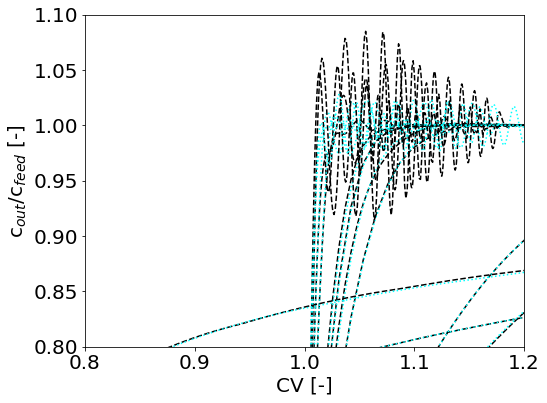

In [32]:
keq = keq_vals[0]

fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel('CV [-]')
ax.set_ylabel(r'c$_{out}$/c$_{feed}$ [-]')

for c_load in load_c_vals:
    for fVolum in fVolum_vals:
        for Dp in Dp_vals:
            for d_part in d_part_vals:
                for l_col in l_col_vals:
                    Ds = explor.get_ds(keq, a_pnas, b_pnas)
                    Dp_eff = Dp + (1.0 - eps_p)/eps_p * keq * Ds

                    with_Ds = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                    no_Ds = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}.h5'
                    no_Ds_better = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc.h5'
                    no_Ds_2 = f'keq_{keq:.2e}_fVolum_{fVolum:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}_Dpeff_{Dp_eff:.1e}_higher_desc_2.h5'

#                     ax.plot(dfs_Ds[with_Ds].CV, dfs_Ds[with_Ds].c_normal)
                    ax.plot(dfs_no_Ds[no_Ds].CV, dfs_no_Ds[no_Ds].c_normal, '--',
                           color='black') # color=plt.gca().lines[-1].get_color())
                    ax.plot(dfs_no_Ds_better[no_Ds_better].CV, 
                            dfs_no_Ds_better[no_Ds_better].c_normal, ':',
                           color='cyan') 
#                     ax.plot(dfs_no_Ds_2[no_Ds_2].CV, 
#                             dfs_no_Ds_2[no_Ds_2].c_normal, '--',
#                            color='magenta')

ax.set_xlim(0.8, 1.2)
ax.set_ylim(0.8, 1.1)

explor.set_layout(fig, ax)


In [ ]:
fracs = np.arange(0.01, 0.81, 0.01)
columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds', 'keq'] + [f'{i:.2f}' for i in fracs]

files = os.listdir('./sim_results_more_comprehensive/')
files = [i for i in files if 'Dpeff' in i]
results = [get_sim_data_keq((file, results_folder)) for file in files]
df_no_Ds = pd.DataFrame(results, columns=columns)
df_no_Ds['v'] = df_no_Ds['fVolum']/(eps_c * area_col)
df_no_Ds['Dp_eff'] = df_no_Ds.Dp + (1.0 - eps_p)/eps_p * df_no_Ds.keq * df_no_Ds.Ds
df_no_Ds['new_x'] = (df_no_Ds['v'] * df_no_Ds['d_part']**2) / (df_no_Ds['Dp_eff'] * df_no_Ds['l_col'])


In [ ]:
df_temp = df_no_Ds[df_no_Ds.keq > 5]

fig, ax = explor.instantiate_fig(8, 6)
# ax.set_ylabel(r'$\frac{\Delta \; CV}{\Delta \; K_{eq} \; (1 - \epsilon_t)}$')
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{wt} \; L_{col}}$')


ax.plot(df_temp['new_x'], (df_temp['0.01']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='1%')
ax.plot(df_temp['new_x'], (df_temp['0.50']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)


# Comprehensive simulations, better discretization


In [9]:
results_folder = Path().absolute() / 'sim_results_updated_discretization'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_updated_discretization'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

In [10]:
eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

In [11]:
fVolum_vals = np.linspace(1.633e-8/3, 1.633e-8*2/3, 3) # for d_c = 0.5 cm, corresponds to 100-200 cm/h
Dp_vals     = np.linspace(5.0e-12, 4.0e-11, 3)
d_part_vals = np.linspace(5.0e-6, 200.0e-6, 4)
l_col_vals  = np.linspace(5.0e-2, 20.0e-2, 2)
keq_vals    = np.logspace(1, 4, 25)[11:]
load_c_vals = np.array([2.0e-5])

In [12]:
def get_t_saturation(V_col, fVolum, eps_t, c_load, q_max):
    return V_col*(1-eps_t)*q_max/fVolum/c_load

def get_t_ILL(V_col, fVolum, eps_t, keq):
    return 2.5*V_col/fVolum*(keq*(1-eps_t) + eps_t)

def get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq):
    t_sat = get_t_saturation(V_col, fVolum, eps_t, c_load, q_max)
    t_ILL = get_t_ILL(V_col, fVolum, eps_t, keq)
    sim_t = min(t_sat, t_ILL)
    
    if sim_t < 5000 or sim_t == t_sat:
        pad = 500
    else:
        pad = 5000
    
    long_pad = 0.1*sim_t
    if long_pad > pad:
        pad = long_pad
    
    sim_t += pad
    return sim_t

## Run - set AB

In [14]:
# ## With multiprocessing
## Manually interrupted - need to read folder contents and 
## try loading data to determine which simulations remain undone

# for c_load in load_c_vals:
#     for Dp in Dp_vals:
        
#         args_list = []
#         for fVolum in fVolum_vals:
#             for l_col in l_col_vals[::-1]:
#                 for keq in keq_vals[::-1]:    
#                     for d_part in d_part_vals[::-1]:
#                         file_name = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
#                         res_file = os.path.join(results_folder, file_name)

#                         V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
#                         t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
#                         ka    = explor.get_ka(keq, q_max)

#                         Ds = explor.get_ds(keq, a_pnas, b_pnas) 

#                         sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
#                                                            eps_c=eps_c, eps_p=eps_p)

#                         args = (sim, res_file)
#                         args_list.append(args)

#         pool      = mp.Pool(processes = mp.cpu_count()-2)
#         results   = pool.map(local_run_sim_fun, args_list)
#         pool.close()
#         pool.join()

In [11]:
files = os.listdir('./sim_results_updated_discretization')

done   = []
undone = []

for c_load in load_c_vals:
    for Dp in Dp_vals:
        
        args_list = []
        for fVolum in fVolum_vals:
            for l_col in l_col_vals[::-1]:
                for keq in keq_vals[::-1]:    
                    for d_part in d_part_vals[::-1]:
                        file_name = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                        try:
                            get_sim_data_2(results_folder, file_name)
                            done.append([c_load, keq, fVolum, Dp, d_part, l_col, file_name])
                        except:
                            undone.append([c_load, keq, fVolum, Dp, d_part, l_col, file_name])


In [12]:
df_done   = pd.DataFrame(done, columns=['c_load', 'keq', 'fVolum', 'Dp', 'd_part', 'l_col', 'file_name'])
df_undone = pd.DataFrame(undone, columns=['c_load', 'keq', 'fVolum', 'Dp', 'd_part', 'l_col', 'file_name'])

df_undone.to_csv('./undone_sims.csv')
df_done.to_csv('./done_sims.csv')

In [13]:
len(df_done), len(df_undone), len(df_undone) + len(df_done)

(815, 193, 1008)

- I need to specify that if Keq > some threshold (maybe 2000), then don't run any simulations with L_col = 20 cm

### Run more

In [16]:
# for Dp in list(set(df_undone.Dp)):
#     df = df_undone[df_undone.Dp == Dp]
    
#     args_list = []
#     for i, cont in df.iterrows():
#         c_load, keq, fVolum, Dp, d_part, l_col, file_name = cont
#         if keq < 2000 or l_col == 0.05:
#             res_file = os.path.join(results_folder, file_name)

#             V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
#             t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
#             ka    = explor.get_ka(keq, q_max)
#             Ds = explor.get_ds(keq, a_pnas, b_pnas) 

#             sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
#                                        eps_c=eps_c, eps_p=eps_p)

#             args = (sim, res_file)
#             args_list.append(args)

#     pool      = mp.Pool(processes = 28)
#     results   = pool.map(local_run_sim_fun, args_list)
#     pool.close()
#     pool.join()

/cload_2.0e-05_keq_1.78e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.78e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.78e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.33e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.33e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.33e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_2.0e-01.h5
/cload_2.0e-05_keq_2.37e+02_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5/cload_2.0e-05_keq_1.33e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_5.0e-06_lcol_2.0e-01.h5

/cload_2.0e-05_keq_1.00e+04_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5
/cload_2.0e-05_keq_1.00e+04_fVolum_5.4e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_5.0e-02.h5
/cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_5.0e-02.h5
/cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_5.0

Simulation completed successfully
Simulation completed successfully
Simulation completed successfully
Simulation completed successfully
Simulation completed successfully


In [14]:
files = os.listdir('./sim_results_updated_discretization')

done   = []
undone = []

for c_load in load_c_vals:
    for Dp in Dp_vals:
        
        args_list = []
        for fVolum in fVolum_vals:
            for l_col in l_col_vals[::-1]:
                for keq in keq_vals[::-1]:    
                    for d_part in d_part_vals[::-1]:
                        file_name = f'cload_{c_load:.1e}_keq_{keq:.2e}_fVolum_{fVolum:.1e}_Dp_{Dp:.1e}_dpart_{d_part:.1e}_lcol_{l_col:.1e}.h5'
                        try:
                            get_sim_data_2(results_folder, file_name)
                            done.append([c_load, keq, fVolum, Dp, d_part, l_col, file_name])
                        except:
                            undone.append([c_load, keq, fVolum, Dp, d_part, l_col, file_name])

df_done   = pd.DataFrame(done, columns=['c_load', 'keq', 'fVolum', 'Dp', 'd_part', 'l_col', 'file_name'])
df_undone = pd.DataFrame(undone, columns=['c_load', 'keq', 'fVolum', 'Dp', 'd_part', 'l_col', 'file_name'])
df_undone.to_csv('./undone_sims.csv')

In [15]:
len(df_undone)

0

In [13]:
for Dp in list(set(df_undone.Dp)):
    df = df_undone[df_undone.Dp == Dp]
    
    args_list = []
    for i, cont in df.iterrows():
        c_load, keq, fVolum, Dp, d_part, l_col, file_name = cont
        res_file = os.path.join(results_folder, file_name)

        V_col = np.pi/4 * (0.5**2) * 1e-4 * l_col # [m3]
        t_max = get_max_sim_time(V_col, fVolum, eps_t, c_load, q_max, keq)
        ka    = explor.get_ka(keq, q_max)
        Ds = explor.get_ds(keq, a_pnas, b_pnas) 

        sim = cad_utils.get_system_updated(load_c=c_load, Dp=Dp, Ds=Ds, q_max=q_max, ka=ka, t_max=t_max, use_linear=False, fVolumetric=fVolum, d_part=d_part, l_col=l_col, 
                                   eps_c=eps_c, eps_p=eps_p)

        args = (sim, res_file)
        args_list.append(args)

    pool      = mp.Pool(processes = 24)
    results   = pool.map(local_run_sim_fun, args_list) 
    pool.close()
    pool.join()

/cload_2.0e-05_keq_1.00e+04_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.00e+04_fVolum_5.4e-09_Dp_5.0e-12_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.00e+04_fVolum_5.4e-09_Dp_5.0e-12_dpart_7.0e-05_lcol_2.0e-01.h5
/cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_5.62e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_5.62e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_4.22e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_4.22e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_1.4e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_3.16e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_2.37e+03_fVolum_5.4e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
/cload_2.0e-05_keq_1.00e+04_fVolum_8.2e-09_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0

### Load

In [ ]:
## With multiprocessing
fracs = np.arange(0.01, 0.81, 0.01)
columns = ['fVolum', 'Dp', 'd_part', 'l_col', 'Ds', 'keq'] + [f'{i:.2f}' for i in fracs]

files = os.listdir('./sim_results_updated_discretization/')
keq_strings = [file[file.find('keq'):file.find('fVolum')] for file in files]
keq_strings = list(set(keq_strings))

for i, keq_str in enumerate(keq_strings):
    file_set = [(file, results_folder) for file in files if keq_str in file]
    pool     = mp.Pool(processes = 10)
    results  = pool.map(get_sim_data_keq, file_set)
    pool.close()
    pool.join()
        
    df_temp = pd.DataFrame(results, columns=columns)
    df_temp['v'] = df_temp['fVolum']/(eps_c * area_col)
    df_temp['Dp_eff'] = df_temp.Dp + (1.0 - eps_p)/eps_p * df_temp.keq * df_temp.Ds
    df_temp['new_x'] = (df_temp['v'] * df_temp['d_part']**2) / (df_temp['Dp_eff'] * df_temp['l_col'])

    if i == 0:
        df = df_temp.copy()
    else:
        df = pd.concat([df, df_temp], ignore_index=True)
    print(i, keq_str)
    
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
# df.to_csv('./updated_discretization_eps_p.csv', index=False)

0 keq_5.62e+02_
1 keq_1.00e+02_
2 keq_2.37e+01_
3 keq_7.50e+02_
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_4.0e-11_dpart_5.0e-06_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_5.0e-12_dpart_7.0e-05_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_4.0e-11_dpart_7.0e-05_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_5.4e-09_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_4.0e-11_dpart_2.0e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_8.2e-09_Dp_4.0e-11_dpart_7.0e-05_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_5.0e-12_dpart_1.4e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_1.1e-08_Dp_5.0e-12_dpart_2.0e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e+03_fVolum_8.2e-09_Dp_4.0e-11_dpart_1.4e-04_lcol_2.0e-01.h5
cload_2.0e-05_keq_7.50e

In [7]:
df_p = pd.read_csv('./updated_discretization_eps_p.csv')
df_t = pd.read_csv('./updated_discretization_eps_t.csv')
df_c = pd.read_csv('./updated_discretization_eps_c.csv')

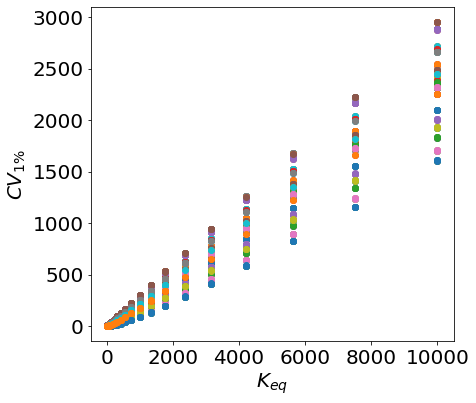

In [14]:
fig, ax = explor.instantiate_fig(7, 6)
ax.set_ylabel(r'$CV_{1\%}$')
ax.set_xlabel(r'$K_{eq}$')
# ax.set_xlim(0, 1300)
# ax.set_ylim(0, 300)

for fVolum in fVolum_vals:
    for Dp in Dp_vals:
        for d_part in d_part_vals:
            for l_col in l_col_vals:
                df_temp = df_p[(df_p.Dp - Dp < 1e-13) & (df_p.d_part == d_part) \
                                & (df_p.l_col == l_col) & (df_p.fVolum == fVolum)].copy()
                
                ax.scatter(df_temp['keq'], df_temp['0.01'])

explor.set_layout(fig, ax)
# fig.savefig('./images_updated_discretization/CV_break.png', dpi=200)

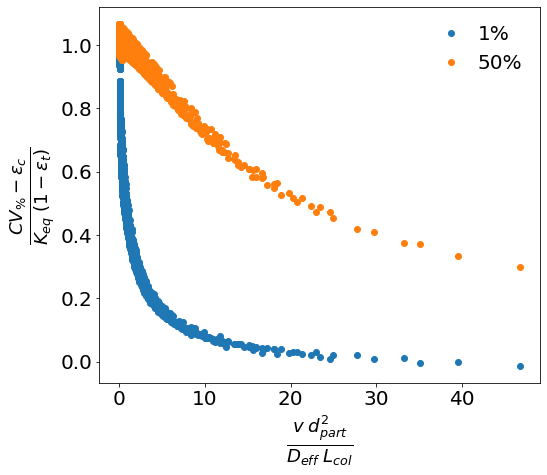

In [13]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_p['new_x'], (df_p['0.01']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='1%')
ax.plot(df_p['new_x'], (df_p['0.50']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
# fig.savefig('./images_updated_discretization/correlation_eps_p.png', dpi=200)

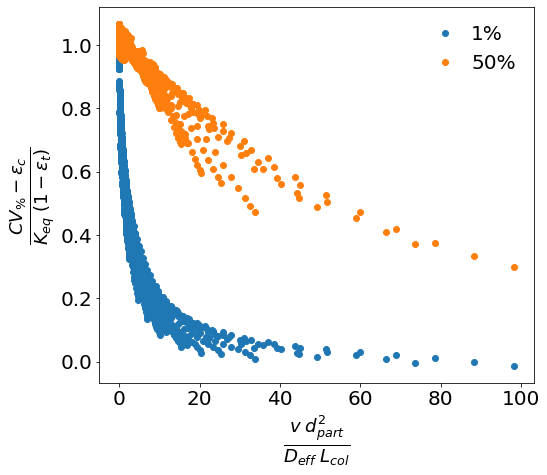

In [14]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_t['new_x'], (df_t['0.01']-eps_c)/((1.0-eps_t)*df_t['keq']), 'o', label='1%')
ax.plot(df_t['new_x'], (df_t['0.50']-eps_c)/((1.0-eps_t)*df_t['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
# fig.savefig('./images_updated_discretization/correlation_eps_t.png', dpi=200)

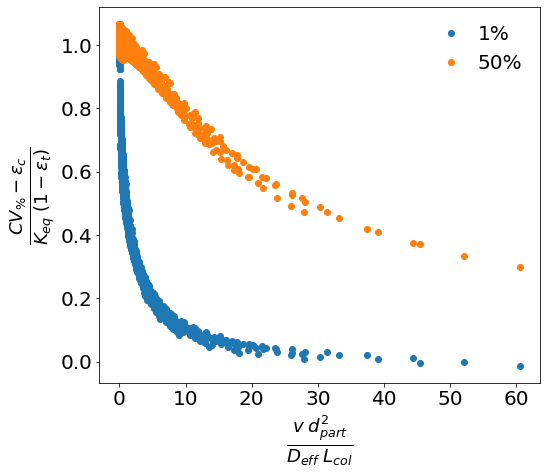

In [15]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_c['new_x'], (df_c['0.01']-eps_c)/((1.0-eps_t)*df_c['keq']), 'o', label='1%')
ax.plot(df_c['new_x'], (df_c['0.50']-eps_c)/((1.0-eps_t)*df_c['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
# fig.savefig('./images_updated_discretization/correlation_eps_c.png', dpi=200)

In [20]:
df = df_p.copy()
df['Dp_eff'] = df.Dp + (1.0 - eps_p)/eps_p * df.keq * df.Ds * 1
df['new_x'] = (df['v'] * df['d_part']**2) / (df['Dp_eff'] * df['l_col'])

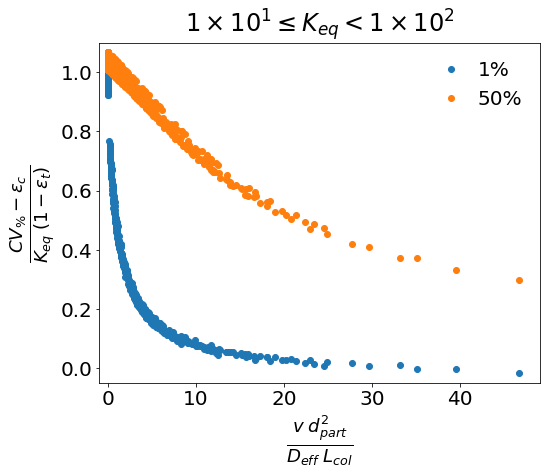

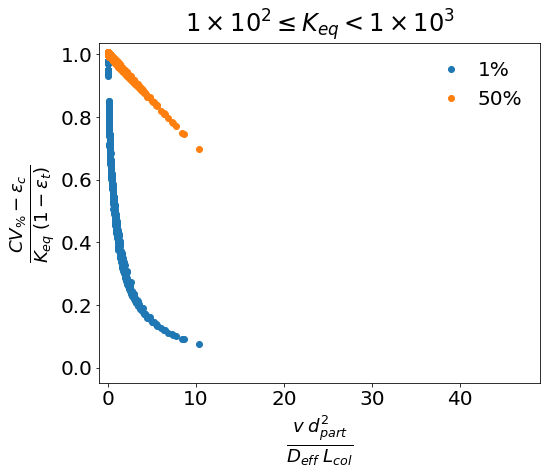

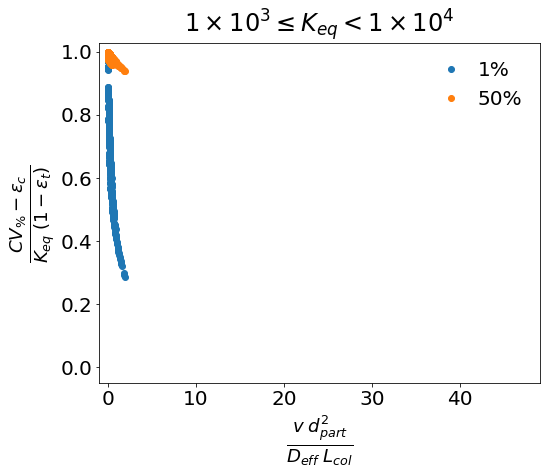

In [21]:
for val in [10, 100, 1000]:
    fig, ax = explor.instantiate_fig(8, 7)
    ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
    ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

    ax.set_title(fr'${as_si(float(val), 0)} \leq K_{{eq}} < {as_si(float(val*10), 0)} $')
    df_temp = df[(df.keq >= val) & (df.keq < val*10)]
    ax.plot(df_temp['new_x'], (df_temp['0.01']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='1%')
    ax.plot(df_temp['new_x'], (df_temp['0.50']-eps_c)/((1.0-eps_t)*df_temp['keq']), 'o', label='50%')
    
    ax.set_xlim(-1, df['new_x'].max()*1.05)
    ax.set_ylim(-0.05, max((df_temp['0.50']-eps_c)/((1.0-eps_t)*df_temp['keq'])*1.03))
    explor.set_layout(fig, ax, legend=True)
    fig.savefig(f'./images_updated_discretization/correlation_keq_geq_{val:.0f}_bounds_varied.png', dpi=200)

In [64]:
vals = list(set(df.v))
vals.sort()
vals

[0.0005657687555244955, 0.0008486531332867433, 0.001131537511048991]

In [63]:
eps_c

0.49

### Look at raw data

In [7]:
results_folder = Path().absolute() / 'sim_results_updated_discretization'
if not os.path.exists( results_folder.as_posix() ):
    os.makedirs( results_folder.as_posix() )
    
image_folder = Path().absolute() / 'images_updated_discretization'
if not os.path.exists( image_folder.as_posix() ):
    os.makedirs( image_folder.as_posix() )

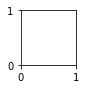

In [8]:
fig, ax = explor.instantiate_fig(1, 1)

In [9]:
files = os.listdir('./sim_results_updated_discretization/')
keq_strings = [file[file.find('keq')+4:file.find('fVolum')-1] for file in files]
keq_strings = list(set(keq_strings))
keq_strings.sort()

0 7.50e+03
0 7.50e+03


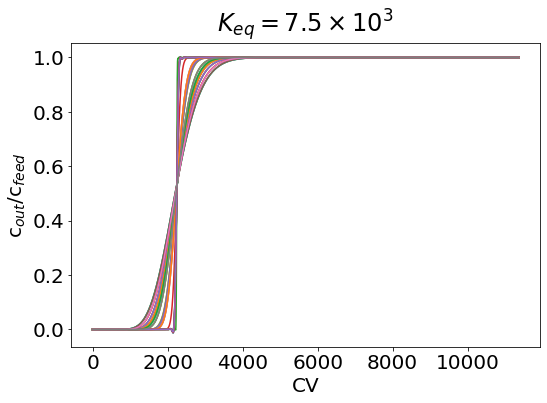

In [12]:
dfs = {}
for i, keq_str in enumerate(keq_strings[-1:]):
    print(i, keq_str)
    file_set = [(results_folder, file) for file in files if keq_str in file]

    fig, ax = explor.instantiate_fig(8, 6)
    ax.set_xlabel('CV')
    ax.set_ylabel(r'c$_{out}$/c$_{feed}$')
    ax.set_title(fr'$K_{{eq}} = {as_si(float(keq_str), 1)}$')
    
    for f in file_set:
        try:
            df_temp = get_sim_data_3(f)
            ax.plot(df_temp.CV, df_temp.c_normal)
            del(df_temp)
        except:
            pass
    
    explor.set_layout(fig, ax)
    fig.savefig(f'./images_updated_discretization/raw_data_keq_{keq_str}.png', dpi=200)

    print(i, keq_str)
    del(file_set, fig, ax)

### Relevant Keq

Fit spline to results from simulation data

In [80]:
eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

In [81]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

df.sort_values(by='new_x', inplace=True)
spl = interpolate.UnivariateSpline(df['new_x'], (df['0.01']-eps_c)/((1.0-eps_t)*df['keq']))
spl.set_smoothing_factor(1.4)

x_vals = np.linspace(df.new_x.min(), df.new_x.max())

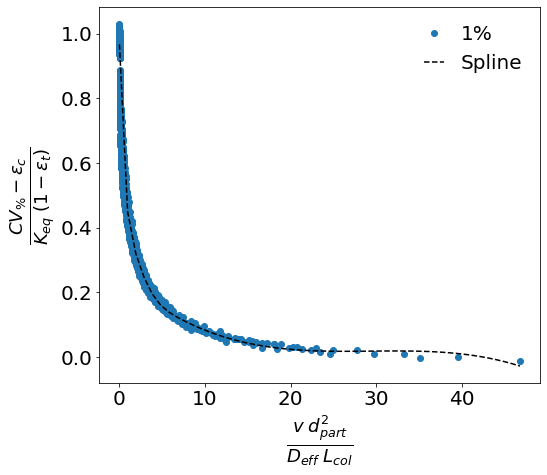

In [82]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df['new_x'], (df['0.01']-eps_c)/((1.0-eps_t)*df['keq']), 'o', label='1%')
ax.plot(x_vals, spl(x_vals), '--', color='black', label='Spline')
# ax.plot(df['new_x'], (df['0.50']-eps_c)/((1.0-eps_t)*df['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
fig.savefig('./images_updated_discretization/correlation_1_percent_spline.png', dpi=200)

Specify new parameters, estimate Keq, and ensure the solver is converging

In [83]:
def get_error(keq, l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load):
    Ds = explor.get_ds(keq, a_pnas, b_pnas)
    Deff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
    
    v = u/(3600 * 100)/eps_c
    x = v * d_part**2 / (Deff * l_col)
    
    eps_t = eps_c + eps_p*(1.0 - eps_c)
    rhs = eps_c + keq * (1.0 - eps_t) * spl(x)
    return cv_load - rhs

In [84]:
l_col = 20e-2
d_part = 50e-6

eps_c = 0.35
eps_p = 0.5
eps_t = eps_c + eps_p*(1.0 - eps_c)

u = 200 # cm/h

Dp = 1.0e-11
a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

cv_load = 50

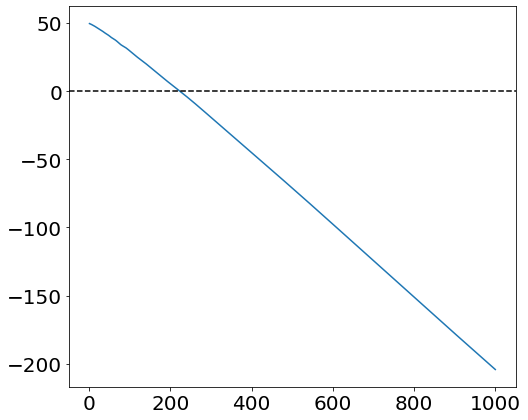

In [85]:
keq_vals = np.linspace(1, 1000, 1000)
errors = [get_error(keq, l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load) for keq in keq_vals]
fig, ax = explor.instantiate_fig(8, 7)
ax.plot(keq_vals, errors)
ax.axhline(0, linestyle='--', color='black')

In [86]:
args=(l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load)
res = optimize.root(get_error, x0=200, args=args)
res

    fjac: array([[-1.]])
     fun: array([2.13162821e-14])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-2.4538295e-08])
       r: array([0.2348052])
  status: 1
 success: True
       x: array([223.20031069])

Plot the problematic Keq/k' over CV_load

In [87]:
def get_kprime(keq, eps_t):
    return (1.0 - eps_t)/eps_t * keq

In [107]:
cv_vals = np.linspace(1, 300, 300)
keq_vals = []

for cv in cv_vals:
    args=(l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv)
    res = optimize.root(get_error, x0=500, args=args)
    assert res.success
    keq_vals.append(res.x[0])

kprime_vals = [get_kprime(keq, eps_t) for keq in keq_vals]

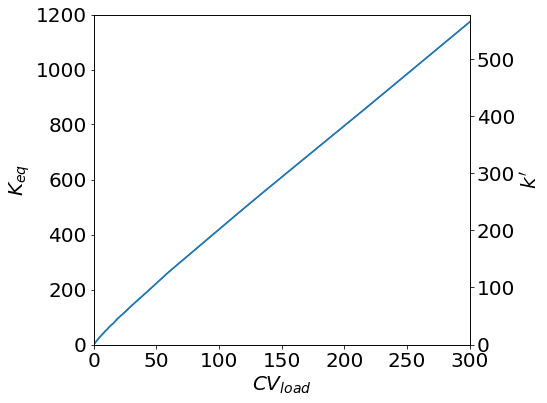

In [109]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel(r'$CV_{load}$')
ax.set_ylabel(r'$K_{eq}$')
ax1 = ax.twinx()
ax1.set_ylabel('$k\'$')

ax.plot(cv_vals, keq_vals)
ax1.plot(cv_vals, kprime_vals)

ax.set_xlim(0, 300)
keq_min, keq_max = 0, 1200
ax.set_ylim(keq_min, keq_max)
ax1.set_ylim(get_kprime(keq_min, eps_t), get_kprime(keq_max, eps_t))

explor.set_layout(fig, ax)
fig.savefig('./images_updated_discretization/keq_of_concern.png', dpi=200)

### Sharpness plot

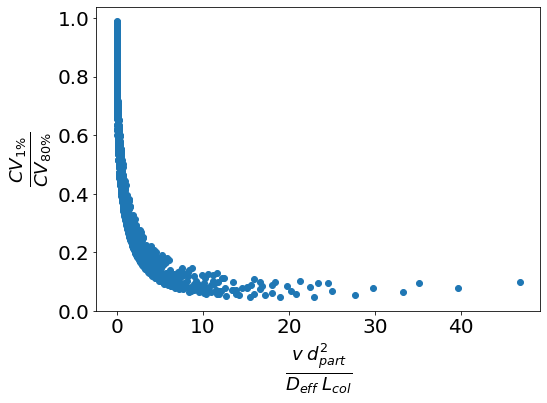

In [301]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{CV_{1\%}}{CV_{80\%}}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_p['new_x'], df_p['0.01']/df_p['0.80'], 'o')
    
explor.set_layout(fig, ax)
fig.savefig('./images_updated_discretization/sharpness_01_80.png', dpi=200)

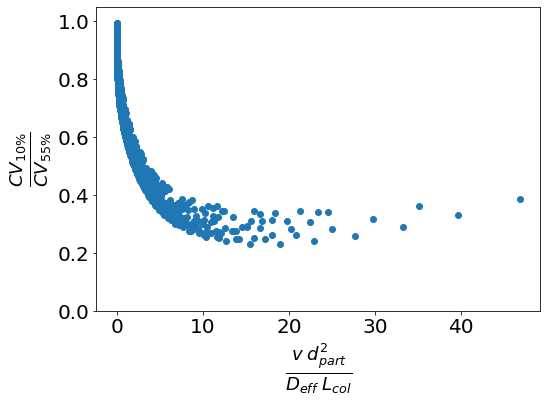

In [322]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{CV_{10\%}}{CV_{55\%}}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_p['new_x'], df_p['0.10']/df_p['0.55'], 'o')
    
ax.set_ylim(0.0, 1.05)
explor.set_layout(fig, ax)
fig.savefig('./images_updated_discretization/sharpness_10_55.png', dpi=200)

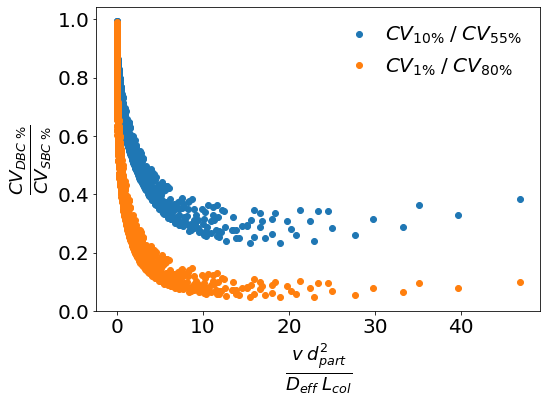

In [315]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{CV_{DBC \; \%}}{CV_{SBC \; \%}}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_p['new_x'], df_p['0.10']/df_p['0.55'], 'o', label=r'$CV_{10\%} \; / \; CV_{55\%}$')
ax.plot(df_p['new_x'], df_p['0.01']/df_p['0.80'], 'o', label=r'$CV_{1\%} \; / \; CV_{80\%}$')
    
explor.set_layout(fig, ax, legend=True)
fig.savefig('./images_updated_discretization/sharpness.png', dpi=200)